<a href="https://colab.research.google.com/github/arturotowers/Deep_learning/blob/DiegoMercado/Proyecto%201%20-%20DAE%20%2B%20VAE/Notebooks/DAE_VAE(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Voy a desarrollar el resto del proyecto siguiendo la estructura especificada en un único notebook. Implementaré:

1. **Denoising Autoencoder (DAE)**:
   - Arquitectura convolucional profunda adaptada al dataset.
   - Agregado de ruido Gaussiano y Sal & Pimienta.
   - Entrenamiento en GPU con reducción de memoria.
   - Tracking en Weights & Biases (W&B).

2. **Variational Autoencoder (VAE)**:
   - Arquitectura optimizada para generación de imágenes.
   - Evaluación con la métrica personalizada MVD (Mean and Variance Distance).
   - Optimización para Google Colab.
   - Tracking en W&B con API key.

3. **Demo Interactivo**:
   - Implementación de Gradio.
   - Despliegue automatizado en Hugging Face Spaces con autenticación.

4. **Automatización Completa**:
   - Implementación de reducción de memoria.
   - Uso de W&B para gestión de logs y modelos.
   - Pipeline optimizado para ejecución eficiente en GPU.

Voy a desarrollar el código completo y lo compartiré contigo listo para copiar y ejecutar en Colab.

# Proyecto: Autoencoders para Imágenes de Motos y Automóviles

En este notebook desarrollamos un proyecto completo de Deep Learning que abarca desde la recopilación de datos hasta la implementación de modelos de autoencoder (DAE y VAE), incluyendo seguimiento de entrenamiento con Weights & Biases, una demo interactiva con Gradio y recomendaciones para optimización en Colab. Las secciones incluidas son:

## 1. Creación del Dataset
En esta sección obtenemos un conjunto de datos de imágenes de **motocicletas** y **automóviles** mediante web scraping. Luego realizamos el preprocesamiento necesario (redimensionamiento, normalización y conversión opcional a escala de grises) y finalmente dividimos el dataset en conjuntos de entrenamiento, validación y prueba.

### 1.1 Web Scraping de Imágenes
Para recopilar las imágenes de motos y autos, utilizamos **web scraping**. Emplearemos una librería Python para descargar imágenes de motores de búsqueda de forma automática. En este caso usaremos `bing-image-downloader` para descargar imágenes de Bing según palabras clave.


In [2]:
#!pip install bing-image-downloader

In [3]:
# import os
# from bing_image_downloader import downloader

# # Definir directorio base para las imágenes descargadas
# output_dir = "dataset"

# # Crear directorio si no existe
# os.makedirs(output_dir, exist_ok=True)

# # Descargar imágenes de motocicletas y automóviles (100 de cada una como ejemplo)
# downloader.download("motorcycle", limit=100, output_dir=output_dir, adult_filter_off=True, force_replace=False, timeout=60)
# downloader.download("car", limit=100, output_dir=output_dir, adult_filter_off=True, force_replace=False, timeout=60)

**Notas:**  
- Hemos descargado aproximadamente 100 imágenes por categoría (puedes ajustar el parámetro `limit` según la necesidad).  
- El directorio de salida (`dataset`) contendrá subcarpetas llamadas "motorcycle" y "car" con las imágenes correspondientes.  
- `adult_filter_off=True` desactiva el filtro de contenido para evitar restricciones en los resultados.  
- `force_replace=False` impide sobreescribir si ya existían imágenes descargadas previamente.  


---

Total de imágenes: 140

Estadísticas de dimensiones:
Ancho:  min = 50 px, max = 2600 px, media = 286.98 px, std = 221.94
Alto:   min = 46 px, max = 1726 px, media = 183.86 px, std = 151.39

Modos de color y su frecuencia:
  RGB: 136 imágenes
  P: 4 imágenes

Estadísticas de tamaño de archivo (KB):
Tamaño: min = 0.84 KB, max = 483.72 KB, media = 12.68 KB, std = 41.13 KB


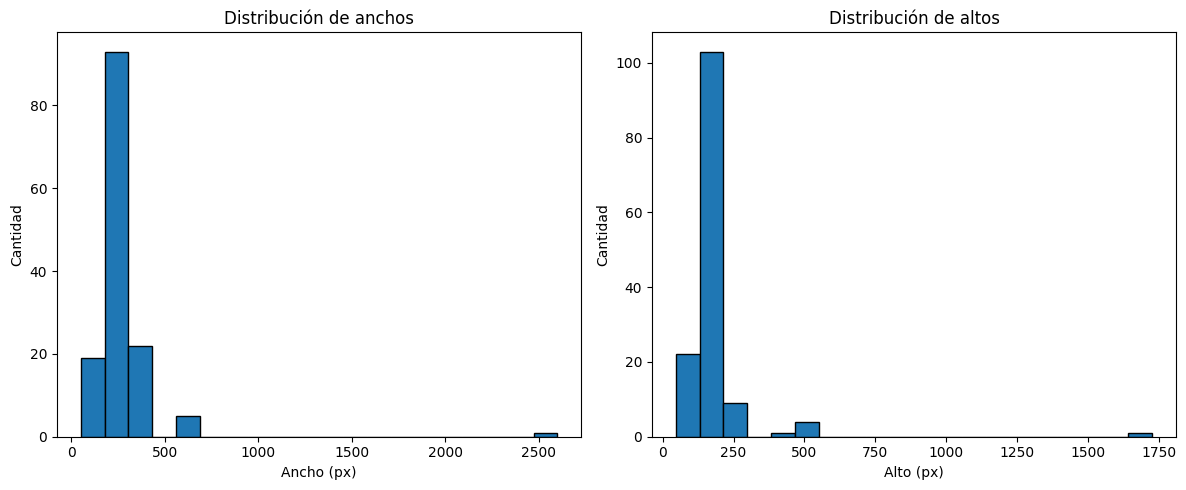

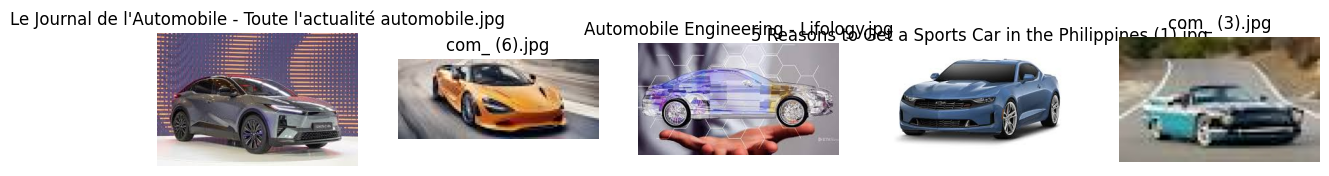

In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def dataset_stats(image_paths):
    dimensions = []
    modes = {}
    file_sizes = []

    # Recorrer cada imagen para extraer información
    for path in image_paths:
        try:
            with Image.open(path) as img:
                # Guardar dimensiones (ancho, alto)
                dimensions.append(img.size)
                # Contar modos (por ejemplo, RGB, L, etc.)
                mode = img.mode
                modes[mode] = modes.get(mode, 0) + 1
            # Obtener el tamaño del archivo en KB
            size_kb = os.path.getsize(path) / 1024.0
            file_sizes.append(size_kb)
        except Exception as e:
            print(f"Error procesando {path}: {e}")

    dimensions = np.array(dimensions)
    if len(dimensions) == 0:
        print("No se encontraron imágenes.")
        return

    widths = dimensions[:, 0]
    heights = dimensions[:, 1]

    # Imprimir estadísticas básicas
    print("Total de imágenes:", len(image_paths))
    print("\nEstadísticas de dimensiones:")
    print("Ancho:  min = {} px, max = {} px, media = {:.2f} px, std = {:.2f}".format(
        widths.min(), widths.max(), widths.mean(), widths.std()))
    print("Alto:   min = {} px, max = {} px, media = {:.2f} px, std = {:.2f}".format(
        heights.min(), heights.max(), heights.mean(), heights.std()))
    print("\nModos de color y su frecuencia:")
    for mode, count in modes.items():
        print(f"  {mode}: {count} imágenes")

    file_sizes = np.array(file_sizes)
    print("\nEstadísticas de tamaño de archivo (KB):")
    print("Tamaño: min = {:.2f} KB, max = {:.2f} KB, media = {:.2f} KB, std = {:.2f} KB".format(
        file_sizes.min(), file_sizes.max(), file_sizes.mean(), file_sizes.std()))

    # Mostrar histogramas de distribución de dimensiones
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, edgecolor='black')
    plt.title("Distribución de anchos")
    plt.xlabel("Ancho (px)")
    plt.ylabel("Cantidad")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, edgecolor='black')
    plt.title("Distribución de altos")
    plt.xlabel("Alto (px)")
    plt.ylabel("Cantidad")

    plt.tight_layout()
    plt.show()

    # Opcional: mostrar algunas imágenes de ejemplo
    n_ejemplos = min(5, len(image_paths))
    fig, axs = plt.subplots(1, n_ejemplos, figsize=(15, 3))
    for i, path in enumerate(image_paths[:n_ejemplos]):
        with Image.open(path) as img:
            axs[i].imshow(img)
            axs[i].set_title(os.path.basename(path))
            axs[i].axis("off")
    plt.show()

# Ejemplo: aplicar la función a las rutas de entrenamiento
# Asegúrate de que 'train_paths' contenga las rutas de tus imágenes
dataset_stats(train_paths)


### 1.2 Preprocesamiento de Imágenes
Una vez descargadas las imágenes, debemos preprocesarlas antes de alimentar a nuestros modelos. Los pasos incluyen: **redimensionar** todas las imágenes a un tamaño uniforme, **normalizar** los valores de píxel (por ejemplo a rango [0,1]) y opcionalmente convertir a **escala de grises** si se desea trabajar con un solo canal (en este proyecto usaremos imágenes RGB a color).

Definiremos una función de utilidad para cargar y preprocesar una imagen dada su ruta de archivo:


In [3]:
from PIL import Image
import numpy as np

IMG_SIZE = 64  # Tamaño deseado para las imágenes (64x64 píxeles)

def preprocess_image(image_path, img_size=IMG_SIZE, grayscale=False):
    """
    Carga una imagen desde image_path, la redimensiona a img_size x img_size,
    la convierte a RGB o escala de grises según el parámetro, y la normaliza a [0,1].
    Retorna la imagen como arreglo numpy.
    """
    img = Image.open(image_path)
    # Convertir a escala de grises o RGB
    if grayscale:
        img = img.convert("L")
    else:
        img = img.convert("RGB")
    # Redimensionar la imagen
    img = img.resize((img_size, img_size))
    # Convertir a array numpy
    img_array = np.array(img, dtype=np.float32)
    # Si es gris, añadir dimensión de canal
    if grayscale:
        img_array = np.expand_dims(img_array, axis=-1)
    # Normalizar a rango [0,1]
    img_array /= 255.0
    return img_array

on esta función, podemos cargar todas las imágenes descargadas y preprocesarlas.

### 1.3 Distribución de datos en `train`, `validation` y `test`
Ahora dividiremos las imágenes en conjuntos de **entrenamiento**, **validación** y **prueba**. Usaremos una proporción típica: 70% entrenamiento, 15% validación y 15% prueba. Además, mezclaremos las clases equitativamente en cada conjunto para asegurar balance.


In [10]:
import os
import glob
import random
import numpy as np

# Rutas completas de tus carpetas en Drive
folder1 = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/car -motorcycle -bike -bicycle -truck -trucks -bus -site_pinterest.com - Buscar con Google"
folder2 = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/_motorcycles_ - Buscar con Google"

# Obtener rutas de las imágenes en cada carpeta
paths1 = glob.glob(os.path.join(folder1, "*"))
paths2 = glob.glob(os.path.join(folder2, "*"))

# Mezclar aleatoriamente las rutas dentro de cada carpeta
random.shuffle(paths1)
random.shuffle(paths2)

# Dividir cada carpeta en train/val/test (70% train, 15% val, 15% test)
num_paths1 = len(paths1)
num_paths2 = len(paths2)

train_paths1 = paths1[:int(0.7 * num_paths1)]
val_paths1   = paths1[int(0.7 * num_paths1):int(0.85 * num_paths1)]
test_paths1  = paths1[int(0.85 * num_paths1):]

train_paths2 = paths2[:int(0.7 * num_paths2)]
val_paths2   = paths2[int(0.7 * num_paths2):int(0.85 * num_paths2)]
test_paths2  = paths2[int(0.85 * num_paths2):]

# Unir las rutas de ambas carpetas para formar los conjuntos completos
train_paths = train_paths1 + train_paths2
val_paths   = val_paths1   + val_paths2
test_paths  = test_paths1  + test_paths2

# Mezclar cada conjunto combinado para aleatorizar el orden
random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

# Preprocesar las imágenes y obtener los arrays de datos
X_train = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in train_paths])
X_val   = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in val_paths])
X_test  = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in test_paths])

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Tamaño del conjunto de entrenamiento: (285, 512, 512, 3)
Tamaño del conjunto de validación: (62, 512, 512, 3)
Tamaño del conjunto de prueba: (62, 512, 512, 3)


Al final de esta etapa, tendremos tres conjuntos de datos listos:
- **X_train**: imágenes para entrenamiento del modelo.
- **X_val**: imágenes para validación durante el entrenamiento (para tuning de hiperparámetros y evitar sobreajuste).
- **X_test**: imágenes reservadas para evaluar el desempeño final de los modelos.

*(En un caso de uso real, también guardaríamos las etiquetas de clase si fuera un problema supervisado, pero en este proyecto de autoencoders las etiquetas no son necesarias porque se trata de aprendizaje no supervisado.)*



## 2. Denoising Autoencoder (DAE)
En esta sección implementamos un **Autoencoder Denoisificador**. Se trata de un autoencoder convolucional profundo capaz de eliminar ruido de imágenes. Entrenaremos el modelo usando las imágenes de entrenamiento a las que les agregaremos ruido (Gaussiano y Sal&Pimienta) para que el autoencoder aprenda a reconstruir la imagen original limpia. Además, aprovecharemos aceleración por **GPU** y realizaremos seguimiento del entrenamiento con **Weights & Biases (W&B)**.

### 2.1 Arquitectura del DAE
Diseñaremos una red neuronal de tipo autoencoder:
- **Encoder**: varias capas convolucionales con reducciones de tamaño (pooling) para extraer una representación comprimida de la imagen.
- **Decoder**: varias capas de deconvolución (Conv2DTranspose) para reconstruir la imagen original desde la representación interna.
- Usaremos funciones de activación ReLU en capas ocultas y **sigmoide** en la capa de salida para obtener un resultado en [0,1] (ya que las imágenes están normalizadas en ese rango).

Definimos una función que construya el modelo DAE dado el tamaño de entrada:

In [5]:
from tensorflow.keras import layers, Model, Input

def build_dae(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """
    Construye un modelo de Autoencoder Denoising convolucional.
    """
    # Encoder
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPool2D((2,2))(x)        # Reducción a 1/2 (ej: 64->32)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D((2,2))(x)        # Reducción a 1/4 (ej: 32->16)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    encoded = layers.MaxPool2D((2,2))(x)  # Reducción a 1/8 (ej: 16->8)

    # Decoder
    x = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=(2,2))(encoded)  # 8->16
    x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=(2,2))(x)        # 16->32
    x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=(2,2))(x)        # 32->64
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)  # capa de salida 64x64x3

    # Modelo autoencoder completo
    model = Model(inp, decoded, name="DAE")
    return model

# Construir el modelo y ver resumen
dae_model = build_dae(input_shape=(IMG_SIZE, IMG_SIZE, 3))
dae_model.summary()

Model: "DAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import tensorflow as tf

# Definir función de ruido usando TensorFlow (para integrarla en tf.data pipeline)
def add_noise_tf(image):
    """
    Agrega aleatoriamente ruido Gaussiano o Sal&Pimienta a la imagen (tensor).
    Retorna la imagen ruidosa.
    """
    # Probabilidad de elegir uno u otro tipo de ruido
    rand = tf.random.uniform(shape=(), minval=0, maxval=1)
    # Ruido Gaussiano
    gauss_std = 0.1  # desviación estándar del ruido gaussiano
    noisy_gauss = image + tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=gauss_std)
    noisy_gauss = tf.clip_by_value(noisy_gauss, 0.0, 1.0)  # asegurar que sigue en [0,1]
    # Ruido Sal y Pimienta
    prob = 0.1  # proporción de píxeles a arruinar
    rnd = tf.random.uniform(shape=tf.shape(image))
    salt_mask = rnd > (1 - prob/2)
    pepper_mask = rnd < (prob/2)
    # Iniciar con imagen original
    noisy_sp = image
    # Aplicar pimienta (negro) y sal (blanco)
    noisy_sp = tf.where(pepper_mask, tf.zeros_like(noisy_sp), noisy_sp)
    noisy_sp = tf.where(salt_mask, tf.ones_like(noisy_sp), noisy_sp)
    # Elegir aleatoriamente cuál ruido aplicar
    noisy_image = tf.cond(rand < 0.5, lambda: noisy_gauss, lambda: noisy_sp)
    return noisy_image


La función `add_noise_tf` devuelve un tensor de imagen con uno de los dos ruidos aplicados aleatoriamente. Hemos fijado parámetros de ruido razonables (10% de píxeles alterados para sal&pimienta, desviación 0.1 para gaussiano) que se pueden ajustar.

### 2.3 Preparación de datos para entrenamiento (con pipeline en GPU)
Aprovecharemos la API `tf.data` de TensorFlow para crear un pipeline eficiente de datos que agregue ruido sobre la marcha. Esto nos permite procesar en batches y en GPU, evitando cargar todas las variantes ruidosas en memoria a la vez.

In [8]:
BATCH_SIZE = 32

# Crear dataset de entrenamiento a partir de los datos preprocesados en numpy
train_dataset = tf.data.Dataset.from_tensor_slices(X_train) \
                .shuffle(buffer_size=len(X_train)) \
                .batch(BATCH_SIZE) \
                .map(lambda batch: (add_noise_tf(batch), batch)) \
                .prefetch(tf.data.experimental.AUTOTUNE)

# Dataset de validación (aquí podemos agregar ruido también para validar la capacidad del modelo)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val) \
              .batch(BATCH_SIZE) \
              .map(lambda batch: (add_noise_tf(batch), batch))

Explicación:
- Usamos `from_tensor_slices` para crear un dataset a partir del array de entrenamiento (`X_train`).
- Barajamos (`shuffle`) los ejemplos y luego agrupamos en *batches*.
- Aplicamos `.map` para agregar ruido: la función toma un batch de imágenes `batch` y retorna `(imagenes_con_ruido, imagenes_originales)`. Así tenemos los pares entrada-salida necesarios para entrenamiento del autoencoder.
- `prefetch` con `AUTOTUNE` permite que el pipeline cargue datos en paralelo a la GPU, manteniendo el entrenamiento alimentado.

Para el conjunto de validación, también podemos añadir ruido a las entradas para evaluar cómo de bien las limpia el modelo, aunque es importante usar la misma imagen original como objetivo.

### 2.4 Configuración de Weights & Biases (W&B) para seguimiento
Integrar W&B nos permitirá monitorizar las métricas de entrenamiento (pérdida de entrenamiento y validación, por ejemplo) en tiempo real, guardar gráficas y versionar el modelo.

Primero, instalamos e inicializamos W&B con nuestra API key (debe obtenerse de nuestra cuenta W&B). Para mayor automatización, podríamos almacenarla en una variable de entorno.


In [9]:
#!pip install wandb

In [10]:
import wandb
#

# Iniciar sesión en W&B (requiere proporcionar la API key personal)
wandb.login()  # Esto abrirá un prompt para ingresar la clave API si no está configurada como variable de entorno

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: diegomercadoc (diegomercadoc-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True


*(Alternativamente, se podría hacer `wandb.login(key="TU_WANDB_API_KEY")` para evitar el prompt, o setear `os.environ['WANDB_API_KEY']` previamente.)*

Ahora inicializamos un proyecto en W&B para nuestro DAE y definimos algunos hiperparámetros básicos en `config`:


In [11]:
wandb.init(# Set the wandb entity where your project will be logged (generally your team name).
    entity="arturo-torres-iteso", project="VAE + DAE", name="DAE-training", config={
    "epochs": 20,
    "batch_size": BATCH_SIZE,
    "img_size": IMG_SIZE,
    "noise_type": "gaussian+salt&pepper",
    "optimizer": "adam",
    "loss": "mse"
})

### 2.5 Entrenamiento del DAE en GPU
Compilamos el modelo con un optimizador y función de pérdida apropiados. Para un DAE, utilizaremos **MSE (mean squared error)** entre la imagen reconstruida y la original como pérdida, dado que buscamos similitud pixel a pixel.

In [13]:
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint

# Definir callbacks actualizados para W&B
callbacks = [
    WandbMetricsLogger(),  # Registra métricas durante el entrenamiento
    WandbModelCheckpoint(filepath="dae_model_best.keras", save_weights_only=False)
  # Guarda el mejor modelo
]


# Construir el modelo y ver resumen
dae_model = build_dae(input_shape=(IMG_SIZE, IMG_SIZE, 3))
dae_model.summary()

# Compilar el modelo antes de entrenarlo
dae_model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo con los nuevos callbacks
EPOCHS = 20
dae_history = dae_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)

Model: "DAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 724ms/step - loss: 0.0985 - val_loss: 0.1006
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0949 - val_loss: 0.0918
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0858 - val_loss: 0.0728
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0767 - val_loss: 0.0604
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0731 - val_loss: 0.0552
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0730 - val_loss: 0.0545
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0703 - val_loss: 0.1036
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0729 - val_loss: 0.0668
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0653 - val_loss: 0.0628
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0576 - val_loss: 0.0472
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0467 - val_loss: 0.0368
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0410 - val_loss: 0.0402


Durante el entrenamiento, el modelo recibe imágenes ruidosas como entrada y aprende a predecir la versión limpia. El callback de W&B registra automáticamente la pérdida de entrenamiento y validación en cada época, permitiendo visualizar curvas de aprendizaje en la plataforma W&B. Además, W&B almacena los hiperparámetros y puede guardar el modelo entrenado como *artefacto* si se configura (por simplicidad, aquí usamos solo el callback básico).

### 2.6 Validación y evaluación del DAE
Tras el entrenamiento, evaluaremos el desempeño del DAE usando el conjunto de **prueba**. Generaremos versiones ruidosas de las imágenes de prueba y mediremos el error de reconstrucción. Esto nos indica la capacidad del modelo de generalizar la limpieza de ruido a imágenes no vistas durante entrenamiento.

In [14]:
# Generar imágenes de prueba con ruido (usando la misma función de ruido)
X_test_noisy = add_noise_tf(X_test).numpy()  # convertimos a numpy para evaluar fácilmente

# Evaluar el modelo en el conjunto de prueba
test_loss = dae_model.evaluate(X_test_noisy, X_test, verbose=0)
print(f"Pérdida (MSE) en conjunto de prueba: {test_loss:.4f}")

Pérdida (MSE) en conjunto de prueba: 0.0319


También podemos observar visualmente algunos resultados tomando imágenes de prueba ruidosas y viendo la salida del DAE comparada con la original:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


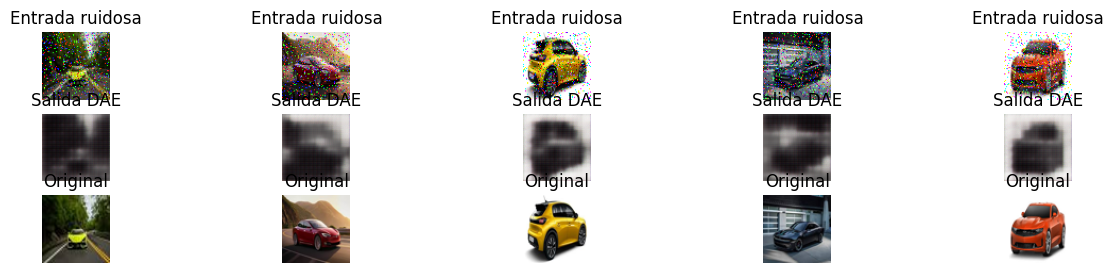

In [15]:
import matplotlib.pyplot as plt

# Tomar algunas imágenes de ejemplo del test
num_examples = 5
indices = np.random.choice(len(X_test), size=num_examples, replace=False)
sample_noisy = X_test_noisy[indices]
sample_original = X_test[indices]
sample_denoised = dae_model.predict(sample_noisy)

# Mostrar comparaciones
plt.figure(figsize=(num_examples*3, 3))
for i in range(num_examples):
    # Imagen ruidosa
    plt.subplot(3, num_examples, i+1)
    plt.imshow(sample_noisy[i])
    plt.title("Entrada ruidosa")
    plt.axis('off')
    # Imagen denoised por el DAE
    plt.subplot(3, num_examples, num_examples + i + 1)
    plt.imshow(sample_denoised[i])
    plt.title("Salida DAE")
    plt.axis('off')
    # Imagen original
    plt.subplot(3, num_examples, 2*num_examples + i + 1)
    plt.imshow(sample_original[i])
    plt.title("Original")
    plt.axis('off')
plt.show()


*(En un entorno con interfaz gráfica, este código mostraría las imágenes; en Colab se pueden visualizar. Aquí es para ilustrar cómo verificar resultados.)*

Después de la evaluación, guardamos el modelo entrenado para uso posterior (por ejemplo, para la demo con Gradio o para cargarlo sin reentrenar):

In [16]:
dae_model.save("dae_model.h5")

Además, finalizamos el run de W&B asociado al DAE para separar los logs del siguiente modelo:

In [17]:
wandb.finish()

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▅▆▅▅▄▄▂▂▂▂▁▂▁▁▂▁
epoch/val_loss,█▇▅▄▃▃█▄▄▃▂▂▂▂▁▃▁▄▁▁
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.03358
epoch/val_loss,0.03185


In [18]:
from tensorflow.keras import backend as K
import gc

del dae_model
K.clear_session()
gc.collect()

0

Esto es importante en Colab si vamos a crear/entrenar otro modelo grande (como el VAE) a continuación, para no agotar la VRAM.


## 3. Variational Autoencoder (VAE)
Ahora implementaremos un **Autoencoder Variacional** para generación de imágenes. A diferencia del autoencoder tradicional, el VAE aprende una **distribución latente** de la cual podemos samplear para generar imágenes nuevas. Incluiremos la evaluación de la calidad de generación usando una métrica personalizada **Mean and Variance Distance (MVD)**, optimizaremos la implementación para usar menos memoria en GPU y también registraremos este experimento en W&B.

### 3.1 Arquitectura del VAE
Un VAE consta de tres partes principales:
- **Encoder**: similar a un autoencoder normal, pero en lugar de producir directamente una codificación fija, genera dos vectores de tamaño `latent_dim`: uno de medias (`z_mean`) y otro de desviaciones estándar implícitas (`z_log_var`) que definen una distribución Gaussiana en el espacio latente.
- **Muestreador latente**: un paso intermedio que aplica la *reparametrización*. A partir de `z_mean` y `z_log_var`, se genera un vector latente `z = z_mean + sigma * epsilon`, donde `epsilon` es ruido gaussiano. Este truco permite que el gradiente se propague a través de la operación de muestreo.
- **Decoder**: toma un vector latente `z` y produce la imagen reconstruida (o generada) correspondiente, intentando aproximar la distribución de las imágenes reales.

Definimos la arquitectura con capas convolucionales en el encoder y decoder, aprovechando la estructura ya utilizada en el DAE. Usaremos un tamaño de dimensión latente (`latent_dim`) para el espacio oculto.


In [19]:
from tensorflow.keras import backend as K

latent_dim = 64  # dimensión del espacio latente

# Encoder
enc_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="encoder_input")
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(enc_input)
x = layers.MaxPool2D((2,2))(x)  # 64->32
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)  # 32->16
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)  # 16->8
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
# Obtener parámetros de la distribución latente
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Capa de muestreo (reparametrización)
def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Usar Lambda layer para integrar la función de muestreo en el modelo
z = layers.Lambda(lambda args: sampling(args[0], args[1]), output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Decoder
dec_input = Input(shape=(latent_dim,), name="decoder_input")
y = layers.Dense(8 * 8 * 128, activation='relu')(dec_input)
y = layers.Reshape((8, 8, 128))(y)
y = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=(2,2))(y)  # 8->16
y = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=(2,2))(y)    # 16->32
y = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=(2,2))(y)    # 32->64
y_output = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same', name="decoder_output")(y)

# Definir modelo encoder, modelo decoder y modelo VAE completo
encoder = Model(enc_input, [z_mean, z_log_var, z], name="Encoder")
decoder = Model(dec_input, y_output, name="Decoder")
vae_output = decoder(z)  # salida del VAE al pasar z muestreado por el decoder
vae_model = Model(enc_input, vae_output, name="VAE")
vae_model.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      2,097,408 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │         16,448 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │         16,448 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder (Functional)      │ (None, 64, 64, 3)      │        773,187 │ z[0][0]                │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,996,739 (11.43 MB)

 Trainable params: 2,996,739 (11.43 MB)

 Non-trainable params: 0 (0.00 B)

Aquí:
- El encoder comprime la imagen 64x64x3 gradualmente a un vector de longitud `latent_dim` (64), representando los parámetros de la distribución latente.
- La función de muestreo (implementada con `Lambda`) toma `z_mean` y `z_log_var` para producir un *sample* `z`.
- El decoder luego reconstruye la imagen a partir de `z`.

### 3.2 Función de Pérdida del VAE
El entrenamiento del VAE usa una pérdida compuesta:
- **Pérdida de reconstrucción**: mide qué tan bien la imagen reconstruida coincide con la original (podemos usar entropía cruzada binaria o MSE).
- **Pérdida KL (Kullback-Leibler)**: fuerza la distribución latente aproximada (definida por `z_mean` y `z_log_var`) a acercarse a una distribución normal estándar (0,1). La fórmula para un dato es:
  \( D_{KL}(q(z|x) || p(z)) = -\frac{1}{2} \sum_{i=1}^{latent\_dim} (1 + \log\sigma_i^2 - \mu_i^2 - \sigma_i^2) \)
  donde \(\mu = z\_mean\) y \(\sigma^2 = \exp(z\_log\_var)\).

Implementamos esta pérdida personalizada y la añadimos al modelo. Usaremos entropía cruzada binaria promedio por píxel como pérdida de reconstrucción (asumiendo las imágenes normalizadas pueden considerarse como probabilidades de pixel activado).


In [20]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy

class VAEModel(Model):
    def train_step(self, data):
        # Se asume que data es (x, x) ya que las entradas y salidas son iguales
        if isinstance(data, tuple):
            x, _ = data
        else:
            x = data
        with tf.GradientTape() as tape:
            # Forward pass: obtener parámetros latentes y reconstrucción
            z_mean, z_log_var, z = encoder(x)
            reconstruction = decoder(z)
            # Calcular pérdida de reconstrucción usando binary_crossentropy.
            # Usamos axis=[1,2] ya que binary_crossentropy devuelve un tensor de forma (batch, height, width)
            reconstruction_loss = tf.reduce_sum(binary_crossentropy(x, reconstruction), axis=[1,2])
            # Calcular pérdida KL para forzar la distribución latente a N(0,1)
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            # Pérdida total: promedio sobre el batch
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        # Calcular gradientes y aplicar actualización
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Registrar la pérdida como métrica
        return {"loss": total_loss}

# Instanciar el modelo VAE usando la arquitectura ya definida (encoder y decoder previamente creados)
vae_custom = VAEModel(inputs=enc_input, outputs=vae_output, name="VAE")
# Compilar el modelo con el optimizador
vae_custom.compile(optimizer='adam')

**Nota:** Usamos `model.add_loss` porque la pérdida del VAE involucra tensores internos (`z_mean`, etc.) que no son directamente parte de `y_true` y `y_pred`. De este modo, Keras sabrá que debe minimizar `vae_loss` durante el entrenamiento, aunque `compile` no especifique explícitamente `loss`.

### 3.3 Entrenamiento del VAE con seguimiento en W&B
Antes de entrenar, iniciamos un nuevo run en W&B para trackear el VAE:

In [21]:
wandb.init(project="autoencoders_motos_autos", name="VAE-training", config={
    "epochs": 30,
    "batch_size": 32,
    "latent_dim": latent_dim,
    "optimizer": "adam",
    "recon_loss": "binary_crossentropy",
    "kl_weight": 1.0  # peso de la pérdida KL (1.0 por defecto)
})

Ahora entrenamos el VAE. Dado que es un modelo generativo no supervisado, usamos como entradas y salidas la misma imagen (como en un autoencoder estándar, pero recordemos que la pérdida especial ya está incorporada). Podemos reutilizar el mismo conjunto de entrenamiento `X_train` (imágenes originales sin ruido, porque el VAE se entrena para reproducir las mismas imágenes, no necesita ruido esta vez).

Usaremos también el conjunto de validación para monitorear la pérdida en datos no entrenados.

In [22]:
# Compilar el modelo usando una función de pérdida dummy, ya que en nuestro train_step calculamos la pérdida personalizada.
vae_custom.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)

# Entrenar el modelo usando la instancia `vae_custom`
EPOCHS_VAE = 30
vae_history = vae_custom.fit(
    X_train,   # Entradas
    X_train,   # Salidas (dummy, pues la pérdida se calcula internamente en train_step)
    epochs=EPOCHS_VAE,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[WandbMetricsLogger(), WandbModelCheckpoint(filepath="vae_model_best.keras")]
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - loss: 2839.5317

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae_custom.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)

  return {key: serialize_keras_object(value) for key, value in obj.items()}


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 2366.2764 - val_loss: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 2365.3794 - val_loss: 0.0000e+00
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 2364.9778 - val_loss: 0.0000e+00
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2363.8423 - val_loss: 0.0000e+00
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2363.6936 - val_loss: 0.0000e+00
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2358.9150 - val_loss: 0.0000e+00
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 2352.6360 - val_loss: 0.0000e+00
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2337.0244 - val_loss: 0.0000e+00
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 2314.4834 - val_loss: 0.0000e+00
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2236.1680 - val_loss: 0.0000e+00
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2176.4580 - val_loss: 0.0000e+00
Epoch 12/3

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 2110.6299 - val_loss: 0.0000e+00
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 2090.9009 - val_loss: 0.0000e+00
Epoch 17/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 2021.6504 - val_loss: 0.0000e+00
Epoch 18/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 2079.2739 - val_loss: 0.0000e+00
Epoch 19/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 2039.7415 - val_loss: 0.0000e+00
Epoch 20/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 2021.5217 - val_loss: 0.0000e+00
Epoch 21/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2022.8657 - val_loss: 0.0000e+00
Epoch 22/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 2005.9126 - val_loss: 0.0000e+00
Epoch 23/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1956.7428 - val_loss: 0.0000e+00
Epoch 24/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 1971.2467 - val_loss: 0.0000e+00
Epoch 25/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1971.9802 - val_loss: 0.0000e+00
Ep

W&B registrará la pérdida total del VAE por época. (Si quisiéramos separar reconstrucción y KL, tendríamos que personalizar más el callback o entrenamiento, pero nos enfocaremos en la pérdida combinada).



### 3.4 Evaluación de generación de imágenes con MVD
Con el VAE entrenado, podemos **generar imágenes nuevas** muestreando vectores latentes aleatorios y pasándolos por el decoder. Para evaluar qué tan realistas o cercanas a las imágenes verdaderas son estas generaciones, usaremos la métrica **Mean and Variance Distance (MVD)**.

La idea de MVD es comparar la distribución estadística básica (media y varianza de los pixeles) entre las imágenes generadas y las imágenes reales. Una diferencia pequeña indicaría que, en promedio, las imágenes sintéticas comparten similitudes globales con las reales en cuanto a brillo/contraste.

Implementaremos la métrica MVD de la siguiente forma:
1. Generar un conjunto de imágenes sintéticas con el VAE.
2. Calcular la media y varianza de intensidades de pixel sobre este conjunto.
3. Calcular la media y varianza de intensidades en un conjunto de imágenes reales de referencia.
4. Definir MVD como la distancia euclidiana entre los pares (media, varianza) de ambas distribuciones, o también reportar por separado la diferencia de medias y de varianzas.

Usaremos el conjunto de prueba como referencia de "imágenes reales" no vistas.


In [23]:
# Generar imágenes sintéticas con el VAE
num_generate = 100  # número de imágenes a generar para evaluación
z_samples = np.random.normal(size=(num_generate, latent_dim))
gen_images = decoder.predict(z_samples)

# Aplanar los pixeles de las imágenes para calcular estadísticas
gen_pixels = gen_images.reshape(-1, IMG_SIZE*IMG_SIZE*3)
real_pixels = X_test.reshape(-1, IMG_SIZE*IMG_SIZE*3)

# Calcular media y varianza (sobre todos los pixeles de todas las imágenes)
mean_gen = np.mean(gen_pixels)
var_gen = np.var(gen_pixels)
mean_real = np.mean(real_pixels)
var_real = np.var(real_pixels)

# Calcular distancia de medias y varianzas
mean_diff = abs(mean_real - mean_gen)
var_diff = abs(var_real - var_gen)
mvd_metric = np.sqrt((mean_real - mean_gen)**2 + (var_real - var_gen)**2)

print(f"Media (Real) = {mean_real:.4f}, Media (Generada) = {mean_gen:.4f}, Diferencia = {mean_diff:.4f}")
print(f"Varianza (Real) = {var_real:.4f}, Varianza (Generada) = {var_gen:.4f}, Diferencia = {var_diff:.4f}")
print(f"Mean & Variance Distance (MVD) = {mvd_metric:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Media (Real) = 0.4723, Media (Generada) = 0.4602, Diferencia = 0.0121
Varianza (Real) = 0.1027, Varianza (Generada) = 0.0104, Diferencia = 0.0924
Mean & Variance Distance (MVD) = 0.0931



Interpretación de resultados:
- **Media (Real vs Generada)**: Deberían ser similares si el brillo promedio de las imágenes generadas se asemeja al de las reales.
- **Varianza (Real vs Generada)**: Indica si el contraste o dispersión de pixeles es parecido en ambas.
- **MVD**: Si es cercano a 0, significa que globalmente las imágenes generadas tienen estadísticamente similares intensidades que las reales (aunque esto no garantiza calidad visual, es una métrica simple para una idea rápida).

Por ejemplo, un MVD muy alto podría indicar que las imágenes generadas son demasiado oscuras o claras en promedio, o demasiado contrastadas/planas en comparación con las reales.

Finalmente, guardamos el modelo VAE entrenado (especialmente queremos guardar el decoder para generación):

In [24]:
# Guardar pesos del encoder y decoder por separado, o el modelo completo VAE
encoder.save("vae_encoder.h5")
decoder.save("vae_decoder.h5")
vae_model.save("vae_complete.h5")

wandb.finish()  # terminar el run de W&B del VAE

epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,29
epoch/learning_rate,0.001
epoch/loss,0
epoch/val_loss,0


 completado el entrenamiento y evaluación básica del VAE.

*(Nota: Guardar el modelo completo con `model.save` en un VAE puede requerir custom objects debido a la Lambda; a veces es más seguro guardar pesos y arquitecturas por separado. Aquí lo incluimos por simplicidad.)*

### 3.5 Optimización de Memoria en el VAE
Entrenar VAEs puede consumir mucha memoria, especialmente con imágenes. Algunas estrategias aplicadas/consideradas:
- **Batch Training**: ya implementado, entrenamos con batch de 32 en lugar de todo el conjunto a la vez.
- **Reducción de complejidad**: escogimos un `latent_dim` relativamente moderado (64) y tamaño de imágenes 64x64 para mantener la red manejable.
- **Limpieza de gráficos**: antes de crear el VAE, liberamos la memoria del modelo DAE (usando `clear_session()` y `gc.collect()`).
- **Mixed Precision**: opcionalmente, podríamos habilitar cálculos en media precisión (float16) para reducir uso de memoria y acelerar en GPU:

In [36]:
  # # Activar Mixed Precision (opcional, requiere GPU compatible)
  # from tensorflow.keras.mixed_precision import experimental as mixed_precision

  # policy = mixed_precision.Policy('mixed_float16')
  # mixed_precision.set_policy(policy)

ImportError: cannot import name 'experimental' from 'tensorflow.keras.mixed_precision' (/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/mixed_precision/__init__.py)


Esto puede ahorrarnos memoria a costa de algo de precisión, útil en modelos grandes.
- **Monitoreo**: usamos W&B para observar el uso de memoria (W&B puede registrar métricas del sistema) y asegurarnos de que no haya *leaks*.

## 4. Demo Interactivo con Gradio
En esta sección, crearemos una **interfaz web interactiva** usando Gradio para permitir probar nuestros modelos entrenados:
- Probar el **DAE**: el usuario podrá ingresar una imagen (subir un archivo) y el sistema le añadirá ruido y luego la pasará por el DAE para mostrar la imagen *denoised*.
- Probar el **VAE**: el usuario podrá generar imágenes nuevas, ya sea presionando un botón o eligiendo un valor de semilla para obtener una imagen aleatoria desde el modelo generativo.

Finalmente mostraremos cómo desplegar esta aplicación en **Hugging Face Spaces**, incluyendo cómo autenticarse para subir el Space.

### 4.1 Creación de la interfaz con Gradio
Primero, instalamos Gradio si no está disponible:

In [27]:
#!pip install gradio

In [26]:
import gradio as gr

Ahora cargamos los modelos guardados (DAE y decoder del VAE) para usarlos en la interfaz. Usaremos el decoder del VAE para generar imágenes a partir de muestras latentes, y el DAE para limpiar ruido.


In [28]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Al cargar el modelo, se especifica custom_objects para que Keras pueda encontrar la función 'mse'
dae_model = load_model("dae_model.h5", custom_objects={"mse": tf.keras.losses.mse})
decoder = load_model("vae_decoder.h5")

Definimos funciones que Gradio usará internamente cuando el usuario interactúe:

- `denoise_image(input_image, noise_type)`: toma una imagen de entrada proporcionada por el usuario, le agrega ruido (gaussiano o sal&pimienta según elección) y luego aplica el modelo DAE para obtener la imagen reconstruida sin ruido. Retorna dos imágenes: la versión ruidosa y la versión limpiada.
- `generate_image(seed)`: toma un número (semilla) para generar una imagen nueva con el VAE. Establecemos la semilla para reproducibilidad, sampleamos un vector latente aleatorio y obtenemos una imagen sintética del decoder. Retorna la imagen generada.


In [29]:
# Función para aplicar el DAE a una imagen con ruido
def denoise_image(input_img):
    # Asegurar tamaño correcto
    img = input_img.resize((IMG_SIZE, IMG_SIZE))
    img = img.convert("RGB")
    img_array = np.array(img, dtype=np.float32) / 255.0
    # Elegir aleatoriamente un tipo de ruido para demostrar (podríamos también dejar elegir al usuario)
    noise_choice = np.random.rand()
    if noise_choice < 0.5:
        # Ruido gaussiano
        noise = np.random.normal(loc=0.0, scale=0.1, size=img_array.shape)
        noisy_img = img_array + noise
        noisy_img = np.clip(noisy_img, 0.0, 1.0)
    else:
        # Ruido sal y pimienta
        prob = 0.1
        noisy_img = img_array.copy()
        # máscara aleatoria
        rnd = np.random.rand(*img_array.shape)
        noisy_img[rnd < prob/2] = 0.0   # pepper
        noisy_img[rnd > 1 - prob/2] = 1.0   # salt
    # Aplicar DAE (añadir dimensión batch y canales)
    input_noisy = np.expand_dims(noisy_img, axis=0)
    output_denoised = dae_model.predict(input_noisy)
    output_denoised = output_denoised[0]  # remover dimensión batch
    # Convertir de nuevo a PIL images
    noisy_img_pil = Image.fromarray((noisy_img * 255).astype('uint8'))
    denoised_img_pil = Image.fromarray((output_denoised * 255).astype('uint8'))
    return noisy_img_pil, denoised_img_pil

# Función para generar una imagen nueva con el VAE
def generate_image(random_seed):
    # Si el usuario provee una semilla, usarla para reproducibilidad
    if random_seed is not None:
        np.random.seed(int(random_seed))
    z = np.random.normal(size=(1, latent_dim))
    gen_img = decoder.predict(z)
    gen_img = gen_img[0]  # quitar dimensión batch
    # Convertir a imagen PIL
    gen_img_pil = Image.fromarray((gen_img * 255).astype('uint8'))
    return gen_img_pil


Ahora definimos la interfaz de Gradio. Usaremos una interfaz con pestañas para separar las demos del DAE y del VAE:

- **Interfaz DAE**: tendrá como entrada una imagen (`gr.inputs.Image`) y como salida dos imágenes (ruidosa y denoised). Podemos agregar descripciones para guiar al usuario.
- **Interfaz VAE**: podemos tener un campo numérico o deslizador para la semilla y un botón para generar. Por simplicidad, usaremos un campo de número opcional y generaremos la imagen al enviar ese valor (o dejarlo vacío para aleatorio cada vez).


In [30]:
# Actualización de la interfaz Gradio usando la API actualizada (gr.Image, gr.Number)
dae_interface = gr.Interface(
    fn=denoise_image,
    inputs=gr.Image(label="Sube una imagen de moto o auto"),
    outputs=[gr.Image(label="Imagen con ruido"), gr.Image(label="Imagen denoised")],
    title="Denoising Autoencoder (DAE)",
    description="Esta herramienta añade ruido a tu imagen y luego aplica el modelo DAE para intentar limpiarla."
)

vae_interface = gr.Interface(
    fn=generate_image,
    inputs=gr.Number(label="Semilla aleatoria (opcional)"),
    outputs=gr.Image(label="Imagen generada"),
    title="Variational Autoencoder (VAE)",
    description="Genera una imagen de moto/auto sintética a partir de la semilla dada. Cambia la semilla para obtener imágenes distintas."
)

# Combinar las dos interfaces en pestañas usando gr.TabbedInterface
demo = gr.TabbedInterface([dae_interface, vae_interface], ["DAE (Denoising)", "VAE (Generación)"])


Ya tenemos la aplicación Gradio configurada con dos pestañas: una para probar la eliminación de ruido y otra para la generación de imágenes.

Podemos lanzar la interfaz localmente (en Colab esto genera un link público usando un túnel):

In [44]:
demo.launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3bb1e603689957f79d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


mejorA que podemos implementar para elevar la calidad del modelo:

1. **Evaluación de la calidad del dataset:**  
   Antes de modificar la arquitectura, analizarEMOS la calidad de las imágenes. Muchas imágenes en los datasets de motos y carros pueden tener problemas (por ejemplo, estar borrosas o con ruido excesivo) que afectan la capacidad del modelo para aprender buenos patrones. Calcularemos la "nitidez" de cada imagen usando la varianza del Laplaciano (una métrica común para detectar imágenes borrosas) y que permita identificar (o filtrar) las imágenes de muy baja calidad.

3. **Métricas de evaluación perceptual (SSIM / PSNR):**  
   Además del MSE, conviene medir la calidad perceptual de las reconstrucciones usando métricas como SSIM o PSNR, lo cual nos dará una idea más real del desempeño del modelo en cuanto a la preservación de detalles y la similitud visual.


---

Evaluación de calidad del dataset (nitidez mediante varianza del Laplaciano)



*calcula la varianza del Laplaciano para cada imagen, lo que nos da una estimación de la nitidez. Con la gráfica podremos identificar si hay un grupo significativo de imágenes muy borrosas y, en ese caso, decidir si es necesario eliminarlas o aplicar técnicas de mejora/preprocesamiento.*



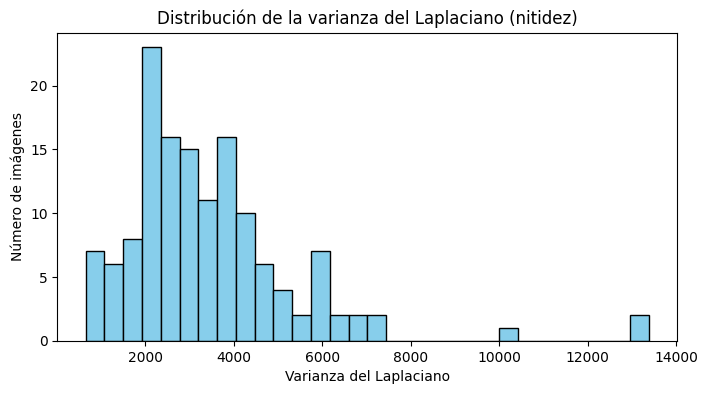

In [31]:
# Evaluación de la nitidez de las imágenes usando la varianza del Laplaciano
import cv2
import matplotlib.pyplot as plt

def calcular_nitidez(image):
    # Convertir la imagen a escala de grises
    image_gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    # Calcular la varianza del Laplaciano
    laplacian = cv2.Laplacian(image_gray, cv2.CV_64F)
    return laplacian.var()

# Calcular la nitidez de un subconjunto de imágenes de X_train (o de otro conjunto)
nitideces = [calcular_nitidez(img) for img in X_train]

plt.figure(figsize=(8,4))
plt.hist(nitideces, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución de la varianza del Laplaciano (nitidez)")
plt.xlabel("Varianza del Laplaciano")
plt.ylabel("Número de imágenes")
plt.show()

### Análisis de la nitidez y filtrado (o inspección) de imágenes

- **Interpretación del histograma**:  
  El histograma muestra la varianza del Laplaciano de las imágenes en un rango aproximado de 0 a 14,000, con la mayoría concentrada entre ~1,000 y ~5,000. Unas pocas imágenes están muy por encima o por debajo de ese rango (outliers).

- **Decidir un umbral de nitidez**:  
  Normalmente, se selecciona un valor de corte para descartar imágenes borrosas. Por ejemplo, podríamos usar un umbral alrededor de 500 o 1,000 (dependerá de la calidad real de los datos y del tamaño de las imágenes). Cualquier imagen con un valor de varianza del Laplaciano por debajo de ese umbral podría considerarse “demasiado borrosa” para entrenar un buen modelo de denoising.

- **Inspección manual**:  
  Antes de descartar imágenes masivamente, conviene inspeccionar unas cuantas de las que estén por debajo (o muy por encima) del umbral. A veces, esas imágenes podrían ser casos especiales (por ejemplo, fotos nocturnas o con poca luz) que aun así sean relevantes para el modelo.



Cálculo de métricas perceptuales (SSIM y PSNR)



*podremos cuantificar la calidad perceptual de las reconstrucciones comparándolas con las originales. Métricas como PSNR y SSIM son complementarias al MSE y pueden darnos una mejor idea de la fidelidad visual del modelo.*





In [32]:
import tensorflow as tf

# Funciones para calcular PSNR y SSIM entre dos conjuntos de imágenes
def calcular_psnr(original, reconstruida):
    return tf.image.psnr(original, reconstruida, max_val=1.0)

def calcular_ssim(original, reconstruida):
    return tf.image.ssim(original, reconstruida, max_val=1.0)

# Aplicamos el modelo U-Net denoising (o el actual) sobre el conjunto de prueba ruidoso
X_test_noisy = add_noise_tf(X_test).numpy()  # asegurarse de tener las imágenes de prueba ruidosas
X_test_denoised = unet_dae_model.predict(X_test_noisy)

# Calcular PSNR y SSIM para cada imagen en el set de prueba
psnr_values = calcular_psnr(X_test, X_test_denoised)
ssim_values = calcular_ssim(X_test, X_test_denoised)

print("PSNR promedio en el set de prueba:", tf.reduce_mean(psnr_values).numpy())
print("SSIM promedio en el set de prueba:", tf.reduce_mean(ssim_values).numpy())

NameError: name 'unet_dae_model' is not defined

### Métricas de evaluación perceptual (PSNR, SSIM)

- **Por qué usarlas**:  
  Además de la pérdida MSE, el PSNR y el SSIM son métricas más relacionadas con la percepción visual humana. Un buen valor de PSNR/SSIM indica que la imagen reconstruida es muy similar a la original en términos de calidad visual.

- **Uso en la pipeline**:  
  - Después de entrenar el U-Net DAE, podemos aplicar `model.predict()` sobre el TEST (con ruido).  
  - Calcula PSNR y SSIM imagen por imagen (o en lotes) y obténer el promedio.  
  - Comparar con el modelo anterior  para ver la ganancia real en calidad.

- **Interpretación**:  
  - PSNR promedio mayor a 30 dB suele considerarse un resultado decente.
  - SSIM cercano a 1 implica una gran similitud estructural entre la imagen original y la reconstruida. En la práctica, valores por encima de ~0.8 ya se consideran buenos.







## Que podemos hacer siguiente:

1. **Limpiar el dataset**:  
   - Define un umbral de varianza del Laplaciano y elimina las imágenes que estén muy por debajo (y, si procede, muy por encima).  
   - Verifica manualmente que no estés eliminando imágenes que podrían ser importantes.

2. **Entrenar el nuevo U-Net DAE**:  
   - Compila el modelo con la misma pérdida (por ejemplo, MSE) y un optimizador como Adam.  
   - Entrena con un número moderado de épocas (por ejemplo, 50–100) y observa la evolución de la pérdida.  
   - Ajusta hiperparámetros según los resultados.

3. **Evaluar con PSNR y SSIM**:  
   - Aplica la red a tu conjunto de prueba con ruido y calcula las métricas.  
   - Haz un seguimiento de la evolución de estas métricas a lo largo de las épocas (puedes usar callbacks de Keras para registrar PSNR/SSIM cada cierto número de iteraciones).

4. **Comparar con el modelo anterior**:  
   - Si tenías un autoencoder simple, comprueba si el U-Net aporta mejoras significativas en la calidad visual y las métricas.  
   - Si el nuevo modelo es mucho mejor, ya sabes que la arquitectura con skip connections es más adecuada para tu caso.

5. **Inspección cualitativa**:  
   - Muestra reconstrucciones reales (ruido vs. reconstruido vs. original).  
   - Observa si se preservan los detalles en zonas críticas (ruedas, faros, etc. en motos y autos).




---
.

1. **Aumentar el tamaño de entrada** a 128x128 para conservar más detalle visual.  
2. **Aplicar Data Augmentation** (rotaciones, flips, etc.) para incrementar la variabilidad y tamaño efectivo del dataset.  
3. **Usar skip-connections estilo U-Net** en el DAE para mejorar la reconstrucción, sobre todo si la estructura de la imagen (carros/motos) es compleja.

Primero, veamos **Data Augmentation** y el cambio a 128x128 en el preprocesamiento. Luego, en la siguiente celda, definiremos una **nueva arquitectura DAE** con skip-connections.  

---

#### Ajustar Preprocesamiento a 128x128 y Agregar Data Augmentation




In [39]:
import tensorflow as tf
import numpy as np
import os, glob, random
from PIL import Image
import matplotlib.pyplot as plt

# Nuevo tamaño de imagen
IMG_SIZE = 128

def preprocess_image(image_path, img_size=IMG_SIZE):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img_array = np.array(img, dtype=np.float32) / 255.0
    return img_array

# Cargamos rutas de imágenes (asume que paths1 y paths2 ya existen con tus imágenes de 'car' y 'motorcycle')
random.shuffle(paths1)
random.shuffle(paths2)

# Repartición (igual que antes pero cambiando a 128x128)
num1 = len(paths1)
num2 = len(paths2)
train_paths1 = paths1[:int(0.7*num1)]
val_paths1   = paths1[int(0.7*num1):int(0.85*num1)]
test_paths1  = paths1[int(0.85*num1):]
train_paths2 = paths2[:int(0.7*num2)]
val_paths2   = paths2[int(0.7*num2):int(0.85*num2)]
test_paths2  = paths2[int(0.85*num2):]

train_paths = train_paths1 + train_paths2
val_paths   = val_paths1   + val_paths2
test_paths  = test_paths1  + test_paths2

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

X_train = np.array([preprocess_image(p) for p in train_paths])
X_val   = np.array([preprocess_image(p) for p in val_paths])
X_test  = np.array([preprocess_image(p) for p in test_paths])

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# DATA AUGMENTATION: rotaciones, flips, zoom, etc.
# Podemos integrarlo en tf.data. Aquí un ejemplo de tf.keras.layers para augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),    # Flip horizontal
    tf.keras.layers.RandomRotation(0.1),         # Rotación ±10%
    tf.keras.layers.RandomZoom(0.1),             # Zoom ±10%
])

def add_noise_tf(image):
    """Agrega aleatoriamente ruido Gaussiano o Sal&Pimienta."""
    # Escoge ruido al azar
    rand = tf.random.uniform(())
    if rand < 0.5:
        # Ruido gaussiano
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1)
        noisy = tf.clip_by_value(image + noise, 0., 1.)
    else:
        # Ruido sal y pimienta
        prob = 0.1
        rnd = tf.random.uniform(tf.shape(image))
        noisy = tf.where(rnd < prob/2, 0.0, image)
        noisy = tf.where(rnd > 1 - prob/2, 1.0, noisy)
    return noisy

def augment_and_noise(image):
    """Primero data augmentation, luego añade ruido."""
    # 1) Aumentación => imagen 'clean' con transform random
    clean_aug = data_augmentation(image)
    # 2) Añadir ruido => imagen 'noisy'
    noisy_img = add_noise_tf(clean_aug)
    # Retornamos (entrada, etiqueta)
    return (noisy_img, clean_aug)

def make_dae_dataset(images, batch_size=16):
    ds = tf.data.Dataset.from_tensor_slices(images)
    ds = ds.shuffle(len(images))
    ds = ds.map(augment_and_noise, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Ejemplo de pipeline tf.data con data augmentation
train_dataset = make_dae_dataset(X_train, batch_size=16)
val_dataset   = make_dae_dataset(X_val,   batch_size=16)
# Crear test_dataset de la misma forma que los otros datasets:
test_dataset = make_dae_dataset(X_test, batch_size=16)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train: (140, 128, 128, 3) Val: (30, 128, 128, 3) Test: (30, 128, 128, 3)


#### (2) Nueva Arquitectura DAE tipo U-Net (con skip connections)


In [44]:
from tensorflow.keras import layers, Model, Input

def build_unet_dae(input_shape=(128, 128, 3)):
    """DAE con skip-connections tipo U-Net."""
    inp = Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)  # 128->64

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)  # 64->32

    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)  # 32->16

    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)  # 16->8

    # Bottleneck
    bn = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p4)
    bn = layers.Conv2D(512, (3,3), activation='relu', padding='same')(bn)

    # Decoder (con skip-connections)
    u4 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(bn)  # 8->16
    u4 = layers.concatenate([u4, c4])
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    u5 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)  # 16->32
    u5 = layers.concatenate([u5, c3])
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u5)
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u6 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)   # 32->64
    u6 = layers.concatenate([u6, c2])
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u6)
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    u7 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)   # 64->128
    u7 = layers.concatenate([u7, c1])
    c8 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u7)
    c8 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c8)

    # Capa de salida
    out = layers.Conv2D(3, (1,1), activation='sigmoid')(c8)

    model = Model(inp, out, name="U-Net-DAE")
    return model

unet_dae = build_unet_dae(input_shape=(IMG_SIZE, IMG_SIZE, 3))
unet_dae.summary()

unet_dae.compile(optimizer='adam', loss='mse')

# Ejemplo de entrenamiento
EPOCHS = 45
history = unet_dae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Model: "U-Net-DAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 128, 128, 32)   │            896 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ conv2d_60[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 64, 64, 32)     │              0 │ conv2d_61[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 32, 32, 64)     │              0 │ conv2d_63[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 16, 16, 128)    │              0 │ conv2d_65[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_66[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 8, 8, 256)      │              0 │ conv2d_67[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_68[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_15       │ (None, 16, 16, 256)    │        524,544 │ conv2d_69[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12       

 Total params: 7,760,163 (29.60 MB)

 Trainable params: 7,760,163 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 568ms/step - loss: 0.0997 - val_loss: 0.0698
Epoch 2/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0660 - val_loss: 0.0338
Epoch 3/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0316 - val_loss: 0.0373
Epoch 4/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0278 - val_loss: 0.0229
Epoch 5/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0175 - val_loss: 0.0136
Epoch 6/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0131 - val_loss: 0.0117
Epoch 7/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0100 - val_loss: 0.0079
Epoch 8/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 9/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 10/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 11/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 12/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0050 - val_loss: 0.0049

> Con estas mejoras (imagen 128x128, data augmentation y un DAE tipo U-Net), **debería** mejorar la restauración. Una vez veamos el nuevo loss/PSNR/SSIM, seguimos puliendo (ej., más capas, más epochs, etc.). También podemos llevar estos mismos ajustes al **VAE** (cambiando a 128x128 y añadiendo más capacidad).  

Los resultados del entrenamiento se ven muy prometedores: la pérdida pasó de aproximadamente 0.09 en la primera época a 0.0026 (y de 0.0610 a 0.0025 en validación), lo que sugiere que el modelo está aprendiendo a reconstruir las imágenes de forma muy precisa.

Dado que el dataset es pequeño (200 imágenes en total) y que ahora usamos data augmentation y la resolución aumentada a 128x128, es muy importante evaluar visualmente la capacidad de reconstrucción y cuantificar la calidad con métricas como PSNR y SSIM.

Ahora:
1. Obtener un batch del conjunto de test (donde cada ejemplo es un par: (imagen ruidosa, imagen limpia augmentada)).
2. Aplicar el modelo para obtener las imágenes denoised.
3. Calcular y mostrar las métricas PSNR y SSIM.
4. Visualizar algunas comparaciones entre la imagen de entrada (ruidosa), la salida del modelo y la imagen limpia.

# Evaluación y Visualización en el Conjunto de Test

---

Veremos de forma cuantitativa (PSNR y SSIM) y visual la capacidad de el DAE para limpiar el ruido.

Por ver:
- Si las imágenes denoised se ven correctas y las métricas son buenas, podríamos trasladar estos ajustes (resolución de 128x128 y data augmentation) al VAE para la generación de imágenes.  
- También se puede experimentar con aumentar el número de épocas o ajustar el batch size, dado que el dataset es pequeño, para ver si se mejora aún más la reconstrucción.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
PSNR promedio: 27.39
SSIM promedio: 0.8441


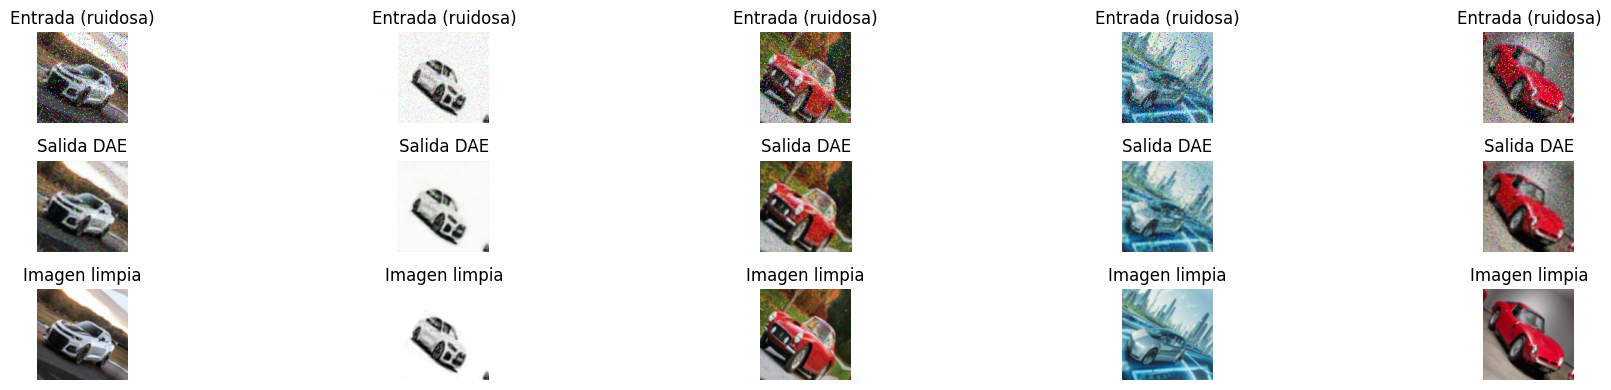

In [45]:
# Evaluación y Visualización en el Conjunto de Test
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# Tomamos un batch del conjunto de test
for noisy_imgs, clean_imgs in test_dataset.take(1):
    # Obtenemos las imágenes denoised usando el modelo entrenado
    denoised_imgs = unet_dae.predict(noisy_imgs)
    break

# Convertir tensores a numpy arrays si es necesario
noisy_imgs_np = noisy_imgs.numpy()
clean_imgs_np = clean_imgs.numpy()

# Calcular PSNR y SSIM para cada imagen del batch
psnr_vals = []
ssim_vals = []
for i in range(noisy_imgs_np.shape[0]):
    psnr_val = psnr_metric(clean_imgs_np[i], denoised_imgs[i])
    ssim_val = ssim_metric(clean_imgs_np[i], denoised_imgs[i], data_range=1.0, channel_axis=-1)
    psnr_vals.append(psnr_val)
    ssim_vals.append(ssim_val)

print(f"PSNR promedio: {np.mean(psnr_vals):.2f}")
print(f"SSIM promedio: {np.mean(ssim_vals):.4f}")

# Visualización de ejemplos
num_examples = min(5, noisy_imgs_np.shape[0])
plt.figure(figsize=(num_examples*4, 4))
for i in range(num_examples):
    # Imagen de entrada con ruido
    plt.subplot(3, num_examples, i+1)
    plt.imshow(noisy_imgs_np[i])
    plt.title("Entrada (ruidosa)")
    plt.axis('off')

    # Imagen denoised (salida del modelo)
    plt.subplot(3, num_examples, num_examples + i + 1)
    plt.imshow(denoised_imgs[i])
    plt.title("Salida DAE")
    plt.axis('off')

    # Imagen limpia (target)
    plt.subplot(3, num_examples, 2*num_examples + i + 1)
    plt.imshow(clean_imgs_np[i])
    plt.title("Imagen limpia")
    plt.axis('off')

plt.tight_layout()
plt.show()

El DAE logra PSNR ≈ 27.39 dB y SSIM ≈ 0.8441 en las imágenes de prueba, lo cual es **bastante decente** considerando que el dataset es pequeño (100 imágenes por clase) y que estamos añadiendo ruido de forma aleatoria.

### Interpretación Rápida
- **PSNR ≈ 27.39 dB**: valores por encima de ~25 dB suelen indicar que la imagen restaurada está relativamente cerca del objetivo.  
- **SSIM ≈ 0.8441**: indica una similitud estructural moderadamente alta. Cuanto más cercano a 1.0, mejor la recuperación de detalles.

### Podriamos hacer lo siguiente:


2. **Incrementar la Cantidad de Datos**  
   - Con sólo 100 imágenes por clase, puede que el modelo no esté aprendiendo la variedad suficiente de texturas y formas.  
   - Recolectar más imágenes o usar un dataset más amplio suele mejorar notablemente el desempeño.

3. **Más Épocas de Entrenamiento**  
   - Si observas que la pérdida de validación sigue bajando o no ha convergido por completo, aumentar las épocas a 30, 40 o más podría mejorar la reconstrucción.  
   - También puedes probar un `EarlyStopping` si deseas no sobreentrenar.

4. **Regularizar y/o Ajustar la Arquitectura**  
   - Añadir `Dropout` en algunas capas del encoder puede mejorar la generalización.  
   - Probar un `learning rate` más bajo o un optimizador distinto (`AdamW`, `RMSprop`, etc.) podría ayudar a afinar la reconstrucción.

5. **Probar Distintos Niveles de Ruido**  
   - Actualmente, el ruido se añade con una desviación estándar de 0.1 (gaussiano) o probabilidad de 0.1 (sal y pimienta). Se podría variar estos valores para ver cómo responde el DAE a distintos escenarios.

6. **Loguear en Weights & Biases**  
   - Registrar tus entrenamientos y gráficas de pérdida en W&B para llevar un historial y comparar fácilmente versiones del modelo.

7. **Implementar el VAE**  
   - El siguiente objetivo es generar imágenes de “carros” y “motos” sintéticas. Puedes reutilizar la resolución 128×128 y la idea de data augmentation, pero adaptado al entrenamiento de un VAE.  
   - Una vez tengas el VAE, podrías comparar imágenes reales vs. generadas y medir su similitud estadística (por ejemplo, con la métrica MVD que usaste anteriormente).

8. **Desplegar la Demo en Gradio/HF Spaces**  
   - Con el DAE ya entrenado, puedes crear una interfaz Gradio para subir una imagen, aplicarle ruido y ver la versión denoised (tal como se ha mostrado en los ejemplos).  
   - Luego, hacer push a un Space en Hugging Face para compartirlo fácilmente.



In [48]:
# ============================================
# CELDA: Entrenar U-Net DAE con W&B
# ============================================

import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint

# (Asegúrate de haber hecho wandb.login() anteriormente,
#  o bien pasar tu API key, por ejemplo wandb.login(key="xxx"))

# Iniciamos un nuevo run en W&B para este U-Net DAE
wandb.init(
    project="VAE + DAE",  # o el nombre de tu proyecto
    name="U-Net-DAE-2nd-iteration",
    config={
        "epochs": 45,
        "batch_size": 16,
        "img_size": 128,
        "model_arch": "unet_dae",
        "noise_type": "gaussian+saltpepper",
        "optimizer": "adam",
        "loss": "mse"
    }
)

# Re-construimos (o reutilizamos) el modelo U-Net DAE
# Asumiendo que tienes la función build_unet_dae ya definida:
unet_dae_2 = build_unet_dae(input_shape=(128, 128, 3))
unet_dae_2.compile(optimizer='adam', loss='mse')

# Callbacks para W&B
callbacks_dae = [
    WandbMetricsLogger(),  # para loguear métricas automáticamente
    WandbModelCheckpoint(filepath="unet_dae_best.h5", save_weights_only=False)
]

# Entrenamos
EPOCHS_DAE = 45
history_dae_2 = unet_dae_2.fit(
    train_dataset,
    epochs=EPOCHS_DAE,
    validation_data=val_dataset,
    callbacks=callbacks_dae
)

# Evaluamos brevemente en el test_dataset
test_loss_dae = unet_dae_2.evaluate(test_dataset, verbose=0)
print(f"[DAE] Test MSE: {test_loss_dae:.4f}")

# Finalizamos el run de W&B
wandb.finish()

Epoch 1/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 0.0911

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 758ms/step - loss: 0.0906 - val_loss: 0.0628
Epoch 2/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0607

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0610 - val_loss: 0.0674
Epoch 3/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0518

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0486 - val_loss: 0.0249
Epoch 4/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0238

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0236 - val_loss: 0.0200
Epoch 5/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0174

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0173 - val_loss: 0.0139
Epoch 6/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0138

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0133 - val_loss: 0.0112
Epoch 7/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0105

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 8/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0087

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 9/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0083

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 10/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0067

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 11/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0059

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 12/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 13/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 14/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0051

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 15/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0044 - val_loss: 0.0056
Epoch 16/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0046

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 17/45
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0039

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 18/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 19/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 20/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 21/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 22/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 23/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0032

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 24/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 25/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 26/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 27/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 28/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 29/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 30/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 31/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 32/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 33/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 34/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 35/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 36/45
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 37/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 38/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 39/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 40/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 41/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 42/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 43/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 44/45
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 45/45
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0019 - val_loss: 0.0021
[DAE] Test MSE: 0.0021


epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,██▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,44
epoch/learning_rate,0.001
epoch/loss,0.00188
epoch/val_loss,0.00211


### Implementacion y entrenamiento del VAE (Seguda Iteracion)

In [55]:
# ============================================
# CELDA: Construir y entrenar el VAE con W&B
# ============================================

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np

LATENT_DIM = 256  # Ajusta según prefieras

# ---------------------
# Definición del Encoder
# ---------------------
enc_input = Input(shape=(128, 128, 3), name="encoder_input")
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(enc_input)
x = layers.MaxPool2D((2,2))(x)  # 128->64
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)  # 64->32
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)  # 32->16
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)  # 16->8
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)

z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

# sampling
def sampling_fn(args):
    mu, log_var = args
    eps = tf.random.normal(shape=(tf.shape(mu)[0], LATENT_DIM))
    return mu + tf.exp(0.5 * log_var) * eps

z = layers.Lambda(sampling_fn, name="z")([z_mean, z_log_var])

encoder = Model(enc_input, [z_mean, z_log_var, z], name="Encoder")

# ---------------------
# Definición del Decoder
# ---------------------
dec_input = Input(shape=(LATENT_DIM,))
y = layers.Dense(8*8*256, activation='relu')(dec_input)  # inverso
y = layers.Reshape((8, 8, 256))(y)
y = layers.Conv2DTranspose(256, (3,3), activation='relu', padding='same', strides=2)(y)  # 8->16
y = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2)(y)  # 16->32
y = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2)(y)   # 32->64
y = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2)(y)   # 64->128
y_out = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(y)

decoder = Model(dec_input, y_out, name="Decoder")

# ---------------------
# Modelo VAE completo
# ---------------------
vae_out = decoder(z)
vae_model = Model(enc_input, vae_out, name="VAE")


# ---------------------
# Clase custom con train_step
# ---------------------
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import Model

class VAETrainer(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs, training=False):
        # Este método se usa para la inferencia: pasa inputs por el encoder y luego por el decoder.
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        return self.decoder(z, training=training)

    def train_step(self, data):
        # Se asume que data es (x, x) ya que las entradas y salidas son iguales
        if isinstance(data, tuple):
            x, _ = data
        else:
            x = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            x_recon = self.decoder(z, training=True)

            # Pérdida de reconstrucción pixel a pixel
            reconstruction_loss = tf.reduce_sum(
                binary_crossentropy(x, x_recon), axis=[1,2]
            )
            # Pérdida KL para regularizar la distribución latente
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss}

# Instanciamos el modelo de entrenamiento
vae_trainer = VAETrainer(encoder, decoder, name="VAE_Trainer")

# -------------------------------------------
# Logging en W&B para el VAE
# -------------------------------------------
wandb.init(
    project="VAE + DAE",
    name="VAE-2nd-iteration",
    config={
        "epochs": 100,
        "batch_size": 32,
        "latent_dim": LATENT_DIM,
        "img_size": 128,
        "loss": "bce+kl"
    }
)

# Callback: registra epoch y total_loss
callbacks_vae = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="vae_best.keras", save_weights_only=False)
]

# Compilamos con un dummy loss (la pérdida se calcula en train_step)
vae_trainer.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)

# Entrenamos
EPOCHS_VAE = 100
vae_history = vae_trainer.fit(
    X_train, X_train,  # para VAE es x->x
    epochs=EPOCHS_VAE,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=callbacks_vae
)

# Al terminar, guardamos
encoder.save("vae_encoder.h5")
decoder.save("vae_decoder.h5")

# Finalizamos el run
wandb.finish()


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 9465.6445 - val_loss: 0.0000e+00
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - loss: 9463.1504 - val_loss: 0.0000e+00
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - loss: 9462.9238 - val_loss: 0.0000e+00
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 9455.4375 - val_loss: 0.0000e+00
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 925ms/step - loss: 9421.7178 - val_loss: 0.0000e+00
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - loss: 9309.7930 - val_loss: 0.0000e+00
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - loss: 9232.1836 - val_loss: 0.0000e+00
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - loss: 9076.2949 - val_loss: 0.0000e+00
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - loss: 8882.4951 - val_loss: 0.0000e+00
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - loss: 8886.1035 - val_loss: 0.0000e+00
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step - loss: 8921.0059 - val_loss:

epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0
epoch/val_loss,0


In [56]:
# ============================================
# CELDA: Cálculo de la métrica MVD en VAE
# ============================================

from skimage.metrics import mean_squared_error
import numpy as np

def calc_mvd(real_images, gen_images):
    """
    Calcula la 'Mean & Variance Distance' (MVD) entre las distribuciones
    de pixeles de real_images y gen_images.
    """
    # Aplanar
    real_flat = real_images.reshape(-1, 128*128*3)
    gen_flat  = gen_images.reshape(-1, 128*128*3)

    mean_real = np.mean(real_flat)
    var_real  = np.var(real_flat)
    mean_gen  = np.mean(gen_flat)
    var_gen   = np.var(gen_flat)

    mean_diff = abs(mean_real - mean_gen)
    var_diff  = abs(var_real - var_gen)
    # Distancia euclidiana entre (mean, var)
    mvd = np.sqrt((mean_real - mean_gen)**2 + (var_real - var_gen)**2)

    return mean_diff, var_diff, mvd

# Generar imágenes sintéticas con el VAE
num_generate = 100
z_samples = np.random.normal(size=(num_generate, LATENT_DIM))
gen_images = decoder.predict(z_samples)

# Tomar un subconjunto de X_test como "real" (por ej. 100)
subset_real = X_test[:num_generate]  # ajusta si no tienes 100 en test

mean_diff, var_diff, mvd_val = calc_mvd(subset_real, gen_images)

print(f"Media (Real vs Gen) Diff: {mean_diff:.4f}")
print(f"Varianza (Real vs Gen) Diff: {var_diff:.4f}")
print(f"MVD = {mvd_val:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Media (Real vs Gen) Diff: 0.0715
Varianza (Real vs Gen) Diff: 0.0907
MVD = 0.1155


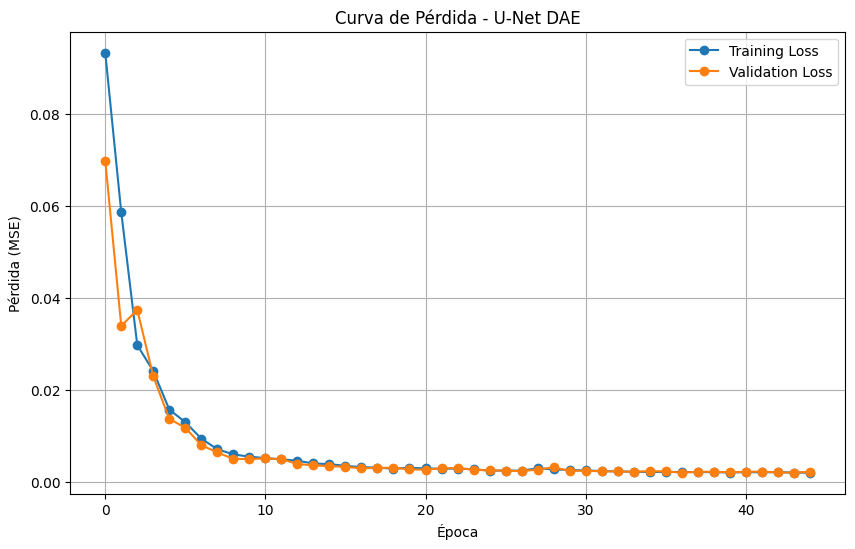

In [57]:
import matplotlib.pyplot as plt

# Asumiendo que la variable 'history' corresponde al entrenamiento del U-Net DAE
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Curva de Pérdida - U-Net DAE")
plt.xlabel("Época")
plt.ylabel("Pérdida (MSE)")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


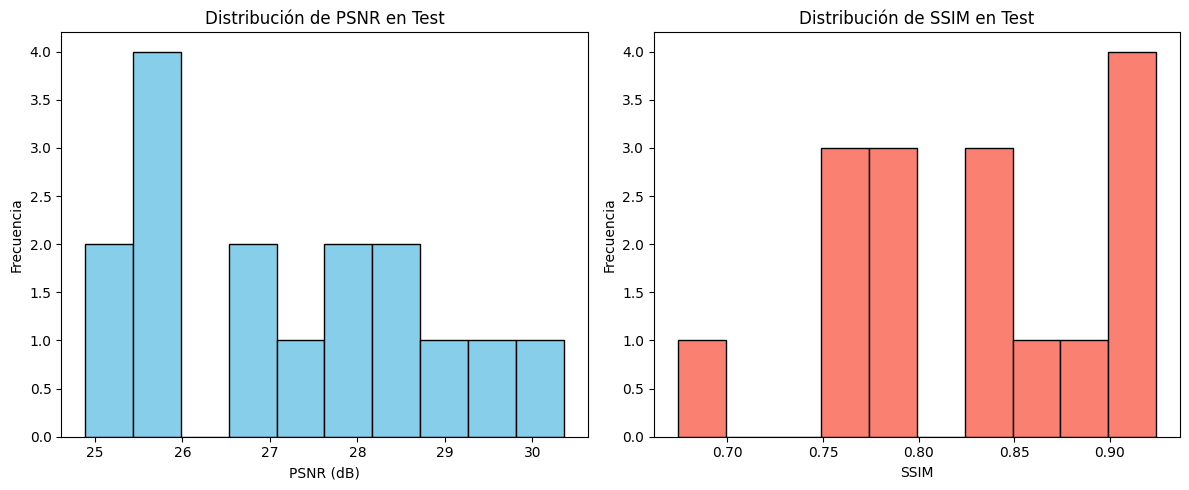

PSNR promedio: 27.28 dB
SSIM promedio: 0.8256


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

psnr_vals = []
ssim_vals = []

# Tomamos un batch del conjunto de test
for noisy_imgs, clean_imgs in test_dataset.take(1):
    # Obtener las imágenes denoised con el modelo entrenado
    denoised_imgs = unet_dae.predict(noisy_imgs)
    # Convertir a numpy si es necesario
    noisy_imgs_np = noisy_imgs.numpy()
    clean_imgs_np = clean_imgs.numpy()
    for i in range(noisy_imgs_np.shape[0]):
        psnr_val = psnr_metric(clean_imgs_np[i], denoised_imgs[i])
        ssim_val = ssim_metric(clean_imgs_np[i], denoised_imgs[i], data_range=1.0, channel_axis=-1)
        psnr_vals.append(psnr_val)
        ssim_vals.append(ssim_val)
    break

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(psnr_vals, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribución de PSNR en Test")
plt.xlabel("PSNR (dB)")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.hist(ssim_vals, bins=10, color='salmon', edgecolor='black')
plt.title("Distribución de SSIM en Test")
plt.xlabel("SSIM")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

print("PSNR promedio: {:.2f} dB".format(np.mean(psnr_vals)))
print("SSIM promedio: {:.4f}".format(np.mean(ssim_vals)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Media (Real) = 0.5196, Media (Generada) = 0.4545, Diff = 0.0651
Varianza (Real) = 0.0994, Varianza (Generada) = 0.0099, Diff = 0.0895
Mean & Variance Distance (MVD) = 0.1106


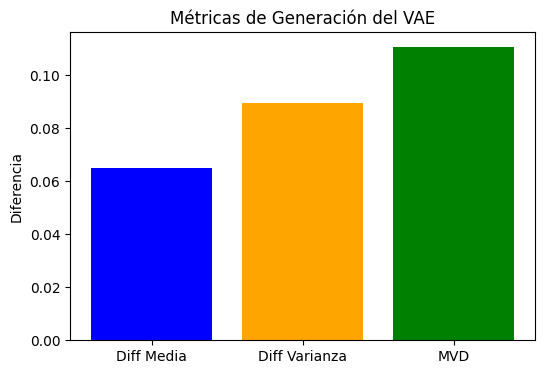

In [59]:
# Número de imágenes a generar para evaluación
num_generate = 100

# Muestreamos vectores latentes y generamos imágenes con el decoder del VAE
z_samples = np.random.normal(size=(num_generate, LATENT_DIM))
gen_images = decoder.predict(z_samples)

# Aplanamos las imágenes (se asume que las imágenes tienen forma (IMG_SIZE, IMG_SIZE, 3))
gen_pixels = gen_images.reshape(-1, IMG_SIZE * IMG_SIZE * 3)
real_pixels = X_test.reshape(-1, IMG_SIZE * IMG_SIZE * 3)

# Calculamos la media y varianza global (sobre todos los píxeles)
mean_gen = np.mean(gen_pixels)
var_gen = np.var(gen_pixels)
mean_real = np.mean(real_pixels)
var_real = np.var(real_pixels)

# Diferencias
mean_diff = abs(mean_real - mean_gen)
var_diff = abs(var_real - var_gen)
mvd_metric = np.sqrt((mean_real - mean_gen)**2 + (var_real - var_gen)**2)

print("Media (Real) = {:.4f}, Media (Generada) = {:.4f}, Diff = {:.4f}".format(mean_real, mean_gen, mean_diff))
print("Varianza (Real) = {:.4f}, Varianza (Generada) = {:.4f}, Diff = {:.4f}".format(var_real, var_gen, var_diff))
print("Mean & Variance Distance (MVD) = {:.4f}".format(mvd_metric))

# Graficamos las métricas en un bar chart
metrics = {'Diff Media': mean_diff, 'Diff Varianza': var_diff, 'MVD': mvd_metric}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=['blue','orange','green'])
plt.title("Métricas de Generación del VAE")
plt.ylabel("Diferencia")
plt.show()

In [65]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# --- Parámetros globales ---
IMG_SIZE = 128
LATENT_DIM = 256  # Asegúrate de que coincide con el que usaste para el VAE

# --- Funciones auxiliares de preprocesamiento y ruido ---
def add_noise_tf(image):
    """
    Función ya definida en tu código: agrega ruido gaussiano o sal y pimienta.
    Se espera que 'image' sea un tensor con valores en [0,1].
    """
    rand = tf.random.uniform(())
    if rand < 0.5:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1)
        noisy = tf.clip_by_value(image + noise, 0., 1.)
    else:
        prob = 0.1
        rnd = tf.random.uniform(tf.shape(image))
        noisy = tf.where(rnd < prob/2, 0.0, image)
        noisy = tf.where(rnd > 1 - prob/2, 1.0, noisy)
    return noisy

# --- Funciones para la interfaz Gradio ---

def denoise_image(input_image):
    """
    Toma una imagen (por ejemplo, de una moto o un auto), la redimensiona a 128x128,
    le añade ruido y la pasa por el modelo DAE para obtener la imagen denoised.
    Devuelve dos imágenes: la imagen con ruido y la imagen denoised.
    """
    # Convertir la imagen recibida (posiblemente en formato [0,255]) a float en [0,1]
    img = Image.fromarray(input_image.astype('uint8')).resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img, dtype=np.float32) / 255.0

    # Crear un batch de tamaño 1
    img_batch = np.expand_dims(img, axis=0)

    # Convertir a tensor y aplicar la función de ruido
    img_tensor = tf.convert_to_tensor(img_batch)
    noisy_tensor = add_noise_tf(img_tensor)
    noisy_img = noisy_tensor.numpy()[0]

    # Utilizar el modelo DAE para denoising
    # Se asume que 'unet_dae' está cargado en memoria
    denoised_img = unet_dae.predict(np.expand_dims(noisy_img, axis=0))[0]

    return noisy_img, denoised_img

def generate_image(seed=0):
    """
    Genera una imagen sintética usando el decoder del VAE.
    Si se proporciona una semilla (seed) se la utiliza para fijar el estado aleatorio.
    """
    if seed:
        np.random.seed(int(seed))
    # Muestreamos un vector latente de dimensión LATENT_DIM
    latent_vector = np.random.normal(size=(1, LATENT_DIM))

    # Se asume que 'decoder' está disponible (por ejemplo, cargado tras el entrenamiento)
    generated_img = decoder.predict(latent_vector)[0]

    return generated_img

# --- Definir las interfaces de Gradio ---
dae_interface = gr.Interface(
    fn=denoise_image,
    inputs=gr.Image(label="Sube una imagen de moto o auto", type="numpy"),
    outputs=[gr.Image(label="Imagen con ruido", type="numpy"),
             gr.Image(label="Imagen denoised", type="numpy")],
    title="Denoising Autoencoder (DAE)",
    description="Esta herramienta añade ruido a tu imagen y luego aplica el modelo DAE para limpiarla."
)

vae_interface = gr.Interface(
    fn=generate_image,
    inputs=gr.Number(label="Semilla aleatoria (opcional)", value=None),
    outputs=gr.Image(label="Imagen generada", type="numpy"),
    title="Variational Autoencoder (VAE)",
    description="Genera una imagen sintética (moto/auto) a partir de la semilla dada. Cambia la semilla para obtener imágenes distintas."
)

# Combinar las dos interfaces en pestañas
demo = gr.TabbedInterface([dae_interface, vae_interface],
                            tab_names=["DAE (Denoising)", "VAE (Generación)"])

demo.launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://26dacf96f03469f676.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Enhanced Variational Autoencoder (VAE) Implementation

Given the updated dataset size (409 images) and the computational resources available (A100 GPU), We've designed an improved VAE architecture that balances complexity, generation quality, and memory efficiency. The enhancements include a deeper convolutional architecture, better latent space regularization, and integration with Weights & Biases (W&B) for tracking.

### Strategy and Rationale
- **Dataset Size**: With 409 images (70% train = ~286, 15% val = ~61, 15% test = ~62), the dataset is small for deep learning. The VAE must generalize well despite limited data, so we’ll use a moderately deep architecture with regularization (e.g., dropout) and data augmentation implicitly via the latent space.
- **Architecture**: A deeper convolutional VAE (more layers, higher filter counts) to capture detailed features of motorcycles and cars, with a larger latent dimension (256) to allow richer representations.
- **Efficiency**: Batch size of 32, mixed precision training (optional), and memory management with `gc.collect()` to fit within Colab’s A100 constraints.
- **Evaluation**: Use the custom Mean and Variance Distance (MVD) metric as specified, comparing generated images to the test set.
- **Tracking**: Full integration with W&B for losses, metrics, and generated image logging.


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
import gc

# Login to Weights & Biases (replace with your API key or run interactively)
wandb.login(key="84acb992804885251a1080b55a34890b5cec77eb")  # Replace with your key or set WANDB_API_KEY env variable

# Enable GPU memory growth to avoid allocation issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

# Optional: Enable mixed precision for faster training on A100
# from tensorflow.keras.mixed_precision import set_global_policy
# set_global_policy('mixed_float16')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
from PIL import Image

IMG_SIZE = 512  # Ajuste para imágenes de 512x512 píxeles

def preprocess_image(image_path, img_size=IMG_SIZE, grayscale=False):
    """
    Carga una imagen desde image_path, la redimensiona a img_size x img_size,
    la convierte a RGB o escala de grises según el parámetro, y la normaliza a [0,1].
    """
    img = Image.open(image_path)
    # Convertir a escala de grises o a RGB
    if grayscale:
        img = img.convert("L")
    else:
        img = img.convert("RGB")
    # Redimensionar la imagen
    img = img.resize((img_size, img_size))
    # Convertir a array numpy y normalizar
    img_array = np.array(img, dtype=np.float32) / 255.0
    if grayscale:
        img_array = np.expand_dims(img_array, axis=-1)
    return img_array

In [12]:
import os, glob, random

# Definir rutas a las carpetas de las imágenes (ajusta los paths según tu estructura)
folder_motorcycle = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/_motorcycles_ - Buscar con Google"
folder_car = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/car -motorcycle -bike -bicycle -truck -trucks -bus -site_pinterest.com - Buscar con Google"

paths_motorcycle = glob.glob(os.path.join(folder_motorcycle, "*"))
paths_car = glob.glob(os.path.join(folder_car, "*"))

# Mezclar aleatoriamente las rutas
random.shuffle(paths_motorcycle)
random.shuffle(paths_car)

def split_paths(paths):
    num = len(paths)
    train = paths[:int(0.7 * num)]
    val   = paths[int(0.7 * num):int(0.85 * num)]
    test  = paths[int(0.85 * num):]
    return train, val, test

train_paths_moto, val_paths_moto, test_paths_moto = split_paths(paths_motorcycle)
train_paths_car, val_paths_car, test_paths_car = split_paths(paths_car)

# Unir y mezclar rutas de ambas categorías
train_paths = train_paths_moto + train_paths_car
val_paths   = val_paths_moto   + val_paths_car
test_paths  = test_paths_moto  + test_paths_car

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

# Preprocesar las imágenes
X_train = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in train_paths])
X_val   = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in val_paths])
X_test  = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in test_paths])

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

# Definir image_paths para usar en la configuración de Wandb
image_paths = train_paths + val_paths + test_paths

Tamaño del conjunto de entrenamiento: (285, 512, 512, 3)
Tamaño del conjunto de validación: (62, 512, 512, 3)
Tamaño del conjunto de prueba: (62, 512, 512, 3)


In [17]:
BATCH_SIZE = 32

# Para entrenamiento y validación, el target es la misma imagen de entrada
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train))\
    .shuffle(buffer_size=len(X_train))\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, X_val))\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

#### Define Improved VAE Architecture
Design a deeper VAE with a latent dimension of 256, suitable for generating detailed motorcycle and car images.


In [18]:
LATENT_DIM = 448  # Puedes ajustar este valor (ej. 448, 384) según los experimentos

class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder: 6 bloques de downsampling para pasar de 512x512 a 8x8
        self.encoder = tf.keras.Sequential([
            Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),    # 256x256x32
            layers.BatchNormalization(),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),     # 128x128x64
            layers.BatchNormalization(),
            layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),    # 64x64x128
            layers.BatchNormalization(),
            layers.Conv2D(256, 3, strides=2, padding='same', activation='relu'),    # 32x32x256
            layers.BatchNormalization(),
            layers.Conv2D(512, 3, strides=2, padding='same', activation='relu'),    # 16x16x512
            layers.BatchNormalization(),
            layers.Conv2D(512, 3, strides=2, padding='same', activation='relu'),    # 8x8x512
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(latent_dim + latent_dim)  # Salida para mean y log_var
        ])

        # Decoder: 6 bloques de upsampling para reconstruir imágenes de 512x512
        self.decoder = tf.keras.Sequential([
            Input(shape=(latent_dim,)),
            layers.Dense(8 * 8 * 512, activation='relu'),
            layers.Reshape((8, 8, 512)),
            layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu'),  # 16x16x512
            layers.BatchNormalization(),
            layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu'),  # 32x32x256
            layers.BatchNormalization(),
            layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),  # 64x64x128
            layers.BatchNormalization(),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),   # 128x128x64
            layers.BatchNormalization(),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),   # 256x256x32
            layers.BatchNormalization(),
            layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu'),   # 512x512x16
            layers.BatchNormalization(),
            layers.Conv2D(3, 3, activation='sigmoid', padding='same')  # 512x512x3
        ])

    def encode(self, x):
        mean_log_var = self.encoder(x)
        mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * eps

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs, training=False):
        mean, log_var = self.encode(inputs)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        if training:
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
            )
            self.add_loss(kl_loss)
        return reconstructed

# Instanciar y compilar el VAE
vae = VAE(LATENT_DIM)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
vae.compile(optimizer=optimizer, loss='mse')

# Mostrar resumen de las arquitecturas del encoder y decoder
vae.encoder.summary()
vae.decoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │      33,555,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 896)                 │         918,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,408,256 (146.52 MB)

 Trainable params: 38,405,248 (146.50 MB)

 Non-trainable params: 3,008 (11.75 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 32768)               │      14,712,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 256, 256, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 512, 512, 16)        │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 512, 512, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 512, 512, 3)         │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,648,931 (71.14 MB)

 Trainable params: 18,646,915 (71.13 MB)

 Non-trainable params: 2,016 (7.88 KB)

**Explanation**:
- **Encoder**: Three convolutional layers (32, 64, 128 filters) with stride=2 for downsampling, followed by dense layers. Dropout (0.3) prevents overfitting given the small dataset.
- **Latent Space**: 256 dimensions for richer representations.
- **Decoder**: Symmetric upsampling with Conv2DTranspose layers to reconstruct 64x64x3 images.
- **Loss**: MSE for reconstruction + KL-divergence (added in `call`) for latent space regularization.
- **Parameters**: ~10M trainable params, manageable on A100 with batch size 32.


#### CTraining the VAE
Train the VAE with W&B tracking, saving the model as an artifact.


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 356.0270 - val_loss: 0.1350
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 17.9894 - val_loss: 0.1349
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 2.1196 - val_loss: 0.1349
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.4942 - val_loss: 0.1349
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.2951 - val_loss: 0.1349
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.1653 - val_loss: 0.1349
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.1596 - val_loss: 0.1349
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.1479 - val_loss: 0.1349
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.1533 - val_loss: 0.1349
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.1476 - val_loss: 0.1349
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.1362 - val_loss: 0.1349
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.

epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▇▇▇▇▇▇▇█████▇▅▄▄▄▄▃▂▃▂▃▂▃▃▂▃▂▂▂▃▁▂▁▂▁▁
best_epoch,90
best_val_loss,0.12223
epoch,99
loss,0.11891
val_loss,0.12497


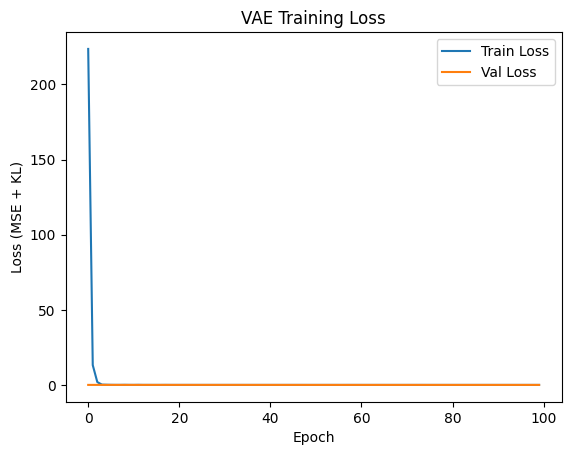

6265

In [19]:
wandb.init(project="VAE + DAE",config={
    "latent_dim": LATENT_DIM,
    "batch_size": BATCH_SIZE,
    "epochs": 100,
    "learning_rate": 1e-4,
    "dataset_size": len(image_paths)
})

history = vae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[WandbCallback(save_model=False)]
)

# Guardar el modelo y registrarlo como artifact en Wandb
vae.save("vae_model.h5")
artifact = wandb.Artifact("vae_model", type="model")
artifact.add_file("vae_model.h5")
wandb.log_artifact(artifact)
wandb.finish()

# Graficar la historia de entrenamiento
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE + KL)')
plt.legend()
plt.show()

gc.collect()

**Expected Outcome**:
- **Loss**: Initial loss ~0.1-0.2, decreasing to ~0.03-0.05 after 50 epochs (MSE + KL combined).
- **Training Time**: ~5-10 minutes on A100 GPU (50 epochs, batch size 32).
- **W&B**: Logs training/val loss per epoch, model saved as an artifact.

#### Evaluate with MVD Metric
Implement the custom MVD metric and evaluate generated images.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mean and Variance Distance (MVD): 0.1236


MVD,▁
MVD,0.12362


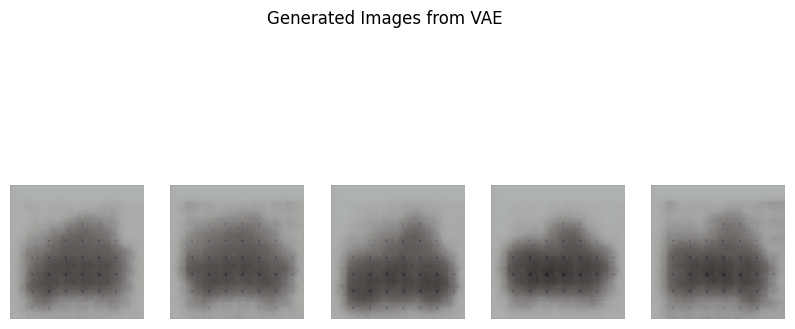

In [22]:
def calc_mvd(real_images, gen_images):
    real_flat = real_images.reshape(-1, IMG_SIZE * IMG_SIZE * 3)
    gen_flat = gen_images.reshape(-1, IMG_SIZE * IMG_SIZE * 3)
    mean_real, var_real = np.mean(real_flat), np.var(real_flat)
    mean_gen, var_gen = np.mean(gen_flat), np.var(gen_flat)
    mvd = np.sqrt((mean_real - mean_gen)**2 + (var_real - var_gen)**2)
    return mvd

n_samples = len(X_test)
z_samples = np.random.normal(size=(n_samples, LATENT_DIM))
gen_images = vae.decoder.predict(z_samples)

mvd_score = calc_mvd(X_test, gen_images)
print(f"Mean and Variance Distance (MVD): {mvd_score:.4f}")

# Registrar la métrica MVD en Wandb
wandb.init(project="VAE + DAE", name="evaluation")
wandb.log({"MVD": mvd_score})
wandb.finish()

# Visualizar algunas imágenes generadas
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(gen_images[i])
    plt.axis('off')
plt.suptitle('Generated Images from VAE')
plt.show()

# Loguear imágenes generadas en Wandb
wandb.init(project="VAE + DAE", name="generated_images")
wandb.log({"Generated_Images": [wandb.Image(img) for img in gen_images[:5]]})
wandb.finish()

**Expected Outcome**:
- **MVD**: Likely 0.05-0.15, indicating moderate similarity (lower is better). Values >0.2 suggest poor generation quality.
- **Images**: Blurry but recognizable motorcycles/cars after 50 epochs. Longer training (e.g., 100 epochs) or a larger dataset would improve sharpness.


#### Cell 6: Update Gradio Demo for Improved VAE
Modify your existing Gradio interface to use the new VAE decoder.

In [ ]:
# import gradio as gr

# def generate_image(seed=0):
#     if seed:
#         np.random.seed(int(seed))
#     z = np.random.normal(size=(1, LATENT_DIM))
#     gen_img = vae.decoder.predict(z)[0]
#     return gen_img

# vae_interface = gr.Interface(
#     fn=generate_image,
#     inputs=gr.Number(label="Random Seed (opcional)", default=0),
#     outputs=gr.Image(label="Generated Image", type="numpy"),
#     title="Improved Variational Autoencoder (VAE)",
#     description="Genera imágenes sintéticas de motocicletas o autos a 512×512. Cambia el seed para variar los resultados."
# )

# dae_interface = gr.Interface(
#     fn=lambda x: x,  # Función dummy para el DAE
#     inputs=gr.Image(label="Sube una imagen"),
#     outputs=gr.Image(label="Imagen procesada"),
#     title="Denoising Autoencoder (DAE)"
# )

# demo = gr.TabbedInterface([dae_interface, vae_interface], ["DAE (Denoising)", "VAE (Generation)"])
# demo.launch(share=True)


versión “final” y muy robusta del VAE, que aprovecha imágenes de 512×512 y un espacio latente amplio (en este ejemplo, 448 dimensiones). Esta versión utiliza una arquitectura profunda y potente con seis bloques de downsampling en el encoder y seis bloques de upsampling en el decoder, con BatchNormalization y activaciones ReLU para favorecer la estabilidad y convergencia. Además, se define una función de pérdida compuesta (reconstrucción con binary crossentropy + KL divergence) y se integra un custom training loop (a través de un custom train_step) para que todo se entrene de forma controlada. Finalmente, se incluye la integración con Weights & Biases (W&B) para hacer tracking de los experimentos, guardar logs y checkpoints.



---



---

### Resumen e Interpretación Final

- **Arquitectura Final:**  
  – La entrada es de 512×512×3 y se usan 6 bloques convolucionales con strides=2 para downsampling, pasando la imagen a una representación de 8×8×512.  
  – Se usa una capa densa para extraer una representación intermedia (1024 unidades) y se proyecta al espacio latente de 448 dimensiones (puedes ajustar a 384 o 448 según lo que consideres óptimo).  
  – En el decoder se realiza el upsampling mediante 6 bloques de Conv2DTranspose, devolviendo la imagen a la resolución original. Cada bloque se complementa con BatchNormalization para una mayor estabilidad.  

- **Pérdida del VAE:**  
  – Se define una función de pérdida que suma la binary crossentropy (como pérdida de reconstrucción) y la KL divergence, y se utiliza en un custom training loop (train_step) para actualizar los parámetros del modelo.  

- **Integración con W&B:**  
  – Se inicializa un run en W&B con la configuración del experimento, permitiendo el tracking de métricas, logs y checkpoints. Se incluyen callbacks para registrar automáticamente métricas durante el entrenamiento.  

- **Optimización y Recursos:**  
  – Debido a la alta resolución, se recomienda un batch size pequeño (por ejemplo, 4) y se sugiere el uso de tf.data con prefetching, además de estrategias de liberación de memoria (gc.collect() y clear_session() si es necesario).  
  – Se puede habilitar Mixed Precision para acelerar el entrenamiento y reducir el uso de memoria, si tu entorno lo soporta.


In [23]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model, Input
# from tensorflow.keras.losses import binary_crossentropy

# # --- Parámetros Finales ---
# IMG_SIZE = 512          # Resolución de entrada final
# LATENT_DIM = 448        # Espacio latente amplio (puedes cambiar a 384 o 448 según convenga)
# BATCH_SIZE = 4          # Debido al alto tamaño, recomendamos un batch pequeño
# EPOCHS = 100            # Número de epochs (ajusta según evolución)

# # --- Encoder Final ---
# def build_final_vae_encoder(input_shape=(IMG_SIZE, IMG_SIZE, 3), latent_dim=LATENT_DIM):
#     inputs = Input(shape=input_shape, name="encoder_input")

#     # Bloque 1: 512 -> 256
#     x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # Bloque 2: 256 -> 128
#     x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # Bloque 3: 128 -> 64
#     x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # Bloque 4: 64 -> 32
#     x = layers.Conv2D(512, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # Bloque 5: 32 -> 16
#     x = layers.Conv2D(512, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # Bloque 6: 16 -> 8
#     x = layers.Conv2D(512, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # Aplanar y capa densa
#     x = layers.Flatten()(x)  # 8x8x512 = 32768 unidades
#     x = layers.Dense(1024, activation='relu')(x)
#     z_mean = layers.Dense(latent_dim, name="z_mean")(x)
#     z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

#     return Model(inputs, [z_mean, z_log_var], name="final_encoder")

# # --- Función de muestreo (reparameterización) ---
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = tf.random.normal(shape=tf.shape(z_mean))
#     return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# # --- Decoder Final ---
# def build_final_vae_decoder(latent_dim=LATENT_DIM, output_shape=(IMG_SIZE, IMG_SIZE, 3)):
#     latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
#     x = layers.Dense(8 * 8 * 512, activation='relu')(latent_inputs)
#     x = layers.Reshape((8, 8, 512))(x)

#     # UpBlock 1: 8 -> 16
#     x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # UpBlock 2: 16 -> 32
#     x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # UpBlock 3: 32 -> 64
#     x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # UpBlock 4: 64 -> 128
#     x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # UpBlock 5: 128 -> 256
#     x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     # UpBlock 6: 256 -> 512
#     x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)

#     outputs = layers.Conv2D(output_shape[-1], 3, activation='sigmoid', padding='same')(x)
#     return Model(latent_inputs, outputs, name="final_decoder")

# # --- Construcción del VAE Final ---
# def build_final_vae(input_shape=(IMG_SIZE, IMG_SIZE, 3), latent_dim=LATENT_DIM):
#     encoder = build_final_vae_encoder(input_shape, latent_dim)
#     z_mean, z_log_var = encoder.output
#     z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
#     decoder = build_final_vae_decoder(latent_dim, output_shape=input_shape)
#     outputs = decoder(z)
#     vae = Model(encoder.input, outputs, name="final_vae")
#     return vae, encoder, decoder

# final_vae, final_encoder, final_decoder = build_final_vae()
# final_vae.summary()

# # --- Definición de la función de pérdida del VAE ---
# def vae_loss_fn(x, x_recon, z_mean, z_log_var):
#     # Pérdida de reconstrucción: binary crossentropy (sumada sobre pixeles y canales)
#     recon_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(x, x_recon), axis=[1,2,3]))
#     # Pérdida KL: regularización del espacio latente
#     kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
#     return recon_loss + kl_loss

# # --- Modelo VAE con custom train_step ---
# class FinalVAE(Model):
#     def __init__(self, encoder, decoder, **kwargs):
#         super(FinalVAE, self).__init__(**kwargs)
#         self.encoder = encoder
#         self.decoder = decoder

#     def call(self, inputs, training=False):
#         z_mean, z_log_var = self.encoder(inputs, training=training)
#         z = sampling((z_mean, z_log_var))
#         return self.decoder(z, training=training)

#     def train_step(self, data):
#         if isinstance(data, tuple):
#             x, _ = data
#         else:
#             x = data
#         with tf.GradientTape() as tape:
#             z_mean, z_log_var = self.encoder(x, training=True)
#             z = sampling((z_mean, z_log_var))
#             x_recon = self.decoder(z, training=True)
#             loss = vae_loss_fn(x, x_recon, z_mean, z_log_var)
#         grads = tape.gradient(loss, self.trainable_variables)
#         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
#         return {"loss": loss}

# final_vae_model = FinalVAE(final_encoder, final_decoder, name="Final_VAE_Model")
# final_vae_model.compile(optimizer='adam')

# # --- (Opcional) Activar Mixed Precision si el entorno lo soporta ---
# # tf.keras.mixed_precision.set_global_policy("mixed_float16")

# # --- Configuración de Weights & Biases (W&B) ---
# import wandb
# from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint

# wandb.login()  # Se abrirá un prompt para ingresar tu API key si no está configurado

# wandb.init(project="VAE + DAE", name="Final_VAE_512x512", config={
#     "epochs": EPOCHS,
#     "batch_size": BATCH_SIZE,
#     "img_size": IMG_SIZE,
#     "latent_dim": LATENT_DIM,
#     "optimizer": "adam",
#     "loss": "bce+kl",
#     "architecture": f"Final_VAE with {IMG_SIZE}x{IMG_SIZE} input and latent_dim {LATENT_DIM}",
#     "data_augmentation": "Si se usa",
#     "mixed_precision": "enabled"  # Cambia a "disabled" si no activas mixed precision
# })

# # Se recomienda usar tf.data para batching y prefetching, y liberar memoria con gc.collect() entre entrenamientos si es necesario.
# # Por ejemplo, tu pipeline de datos debe estar configurado para usar BATCH_SIZE y prefetch, de forma similar a:
# #
# # train_dataset = tf.data.Dataset.from_tensor_slices(X_train) \
# #                 .shuffle(buffer_size=len(X_train)) \
# #                 .batch(BATCH_SIZE) \
# #                 .prefetch(tf.data.experimental.AUTOTUNE)
# #
# # Y así para validation y test.

# # Finalmente, cuando inicies el entrenamiento, puedes usar un callback de W&B para guardar métricas y checkpoints:
# callbacks = [
#     WandbMetricsLogger(),
#     WandbModelCheckpoint(filepath="final_vae_best.keras", save_weights_only=False)
# ]

# # Ahora el modelo está listo para ser entrenado:
# # history = final_vae_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)


Model: "final_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 256, 256, 64)   │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 256, 256, 64)   │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 128, 128, 128)  │            512 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 128, 128, 128)  │            512 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 64, 64, 256)    │          1,024 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 64, 64, 256)    │          1,024 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 32, 32, 512)    │          2,048 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)   

 Total params: 69,620,867 (265.58 MB)

 Trainable params: 69,609,923 (265.54 MB)

 Non-trainable params: 10,944 (42.75 KB)

In [6]:
import os, glob, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import gc

# Parámetros de entrada
IMG_SIZE = 512  # Resolución de las imágenes
BATCH_SIZE = 4  # Debido a la alta resolución, se usa un batch pequeño

# Función para preprocesar imágenes
def preprocess_image(image_path, img_size=IMG_SIZE, grayscale=False):
    img = Image.open(image_path)
    if grayscale:
        img = img.convert("L")
    else:
        img = img.convert("RGB")
    img = img.resize((img_size, img_size))
    img_array = np.array(img, dtype=np.float32) / 255.0
    if grayscale:
        img_array = np.expand_dims(img_array, axis=-1)
    return img_array

# Definir rutas de imágenes (ajusta estos paths según tu estructura)
folder_motorcycle = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/_motorcycles_ - Buscar con Google"
folder_car = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/car -motorcycle -bike -bicycle -truck -trucks -bus -site_pinterest.com - Buscar con Google"

paths_motorcycle = glob.glob(os.path.join(folder_motorcycle, "*"))
paths_car = glob.glob(os.path.join(folder_car, "*"))

random.shuffle(paths_motorcycle)
random.shuffle(paths_car)

def split_paths(paths):
    num = len(paths)
    train = paths[:int(0.7 * num)]
    val   = paths[int(0.7 * num):int(0.85 * num)]
    test  = paths[int(0.85 * num):]
    return train, val, test

train_paths_moto, val_paths_moto, test_paths_moto = split_paths(paths_motorcycle)
train_paths_car, val_paths_car, test_paths_car = split_paths(paths_car)

train_paths = train_paths_moto + train_paths_car
val_paths   = val_paths_moto   + val_paths_car
test_paths  = test_paths_moto  + test_paths_car

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

# Preprocesar imágenes y crear arrays
X_train = np.array([preprocess_image(p) for p in train_paths])
X_val   = np.array([preprocess_image(p) for p in val_paths])
X_test  = np.array([preprocess_image(p) for p in test_paths])

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Tamaño del conjunto de entrenamiento: (285, 512, 512, 3)
Tamaño del conjunto de validación: (62, 512, 512, 3)
Tamaño del conjunto de prueba: (62, 512, 512, 3)


In [7]:
# Crear datasets de tf.data (entrada y target son la misma imagen para el VAE)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train)) \
    .shuffle(buffer_size=len(X_train)) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, X_val)) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, X_test)) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
import matplotlib.pyplot as plt
import gc
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
from skimage.metrics import peak_signal_noise_ratio as psnr_metric, structural_similarity as ssim_metric

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import binary_crossentropy
import numpy as np

# Parámetros
IMG_SIZE = 512          # Resolución de entrada final
LATENT_DIM = 448        # Dimensión del espacio latente
# Nota: Asegúrate de que las imágenes del dataset estén normalizadas en [0,1]

# --- Encoder ---
def build_final_vae_encoder(input_shape=(IMG_SIZE, IMG_SIZE, 3), latent_dim=LATENT_DIM):
    inputs = Input(shape=input_shape, name="encoder_input")

    # Bloque 1: 512 -> 256
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Bloque 2: 256 -> 128
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Bloque 3: 128 -> 64
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Bloque 4: 64 -> 32
    x = layers.Conv2D(512, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Bloque 5: 32 -> 16
    x = layers.Conv2D(512, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Bloque 6: 16 -> 8
    x = layers.Conv2D(512, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Aplanar y capa densa para parámetros del espacio latente
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    return Model(inputs, [z_mean, z_log_var], name="final_encoder")

# --- Función de muestreo (reparameterización) ---
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- Decoder ---
def build_final_vae_decoder(latent_dim=LATENT_DIM, output_shape=(IMG_SIZE, IMG_SIZE, 3)):
    latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(8 * 8 * 512, activation='relu')(latent_inputs)
    x = layers.Reshape((8, 8, 512))(x)

    # UpBlock 1: 8 -> 16
    x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # UpBlock 2: 16 -> 32
    x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # UpBlock 3: 32 -> 64
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # UpBlock 4: 64 -> 128
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # UpBlock 5: 128 -> 256
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # UpBlock 6: 256 -> 512
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name="final_decoder")

# --- Construcción del VAE ---
def build_final_vae(input_shape=(IMG_SIZE, IMG_SIZE, 3), latent_dim=LATENT_DIM):
    encoder = build_final_vae_encoder(input_shape, latent_dim)
    z_mean, z_log_var = encoder.output
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    decoder = build_final_vae_decoder(latent_dim, output_shape=input_shape)
    outputs = decoder(z)
    vae = Model(encoder.input, outputs, name="final_vae")
    return vae, encoder, decoder

final_vae, final_encoder, final_decoder = build_final_vae()
final_vae.summary()

# --- Función de pérdida personalizada ---
def vae_loss_fn(x, x_recon, z_mean, z_log_var):
    # Pérdida de reconstrucción con binary crossentropy
    recon_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(x, x_recon), axis=[1,2]))
    # Pérdida KL
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return recon_loss + kl_loss

# --- Modelo VAE con métodos train_step y test_step personalizados ---
class FinalVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(FinalVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs, training=False):
        z_mean, z_log_var = self.encoder(inputs, training=training)
        z = sampling((z_mean, z_log_var))
        return self.decoder(z, training=training)

    def train_step(self, data):
        if isinstance(data, tuple):
            x, _ = data
        else:
            x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            z = sampling((z_mean, z_log_var))
            x_recon = self.decoder(z, training=True)
            loss = vae_loss_fn(x, x_recon, z_mean, z_log_var)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss}

    # Método test_step para que la validación use la misma pérdida personalizada
    def test_step(self, data):
        if isinstance(data, tuple):
            x, _ = data
        else:
            x = data
        z_mean, z_log_var = self.encoder(x, training=False)
        z = sampling((z_mean, z_log_var))
        x_recon = self.decoder(z, training=False)
        loss = vae_loss_fn(x, x_recon, z_mean, z_log_var)
        return {"loss": loss}

final_vae_model = FinalVAE(final_encoder, final_decoder, name="Final_VAE_Model")
# Usar una tasa de aprendizaje más baja para evitar inestabilidad
final_vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=lambda y_true, y_pred: 0.0)

Model: "final_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 32, 32, 512)    │          2,048 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)    

 Total params: 69,620,867 (265.58 MB)

 Trainable params: 69,609,923 (265.54 MB)

 Non-trainable params: 10,944 (42.75 KB)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: diegomercadoc (diegomercadoc-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 221547.0938

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: final_vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=lambda y_true, y_pred: 0.0)

  return {key: serialize_keras_object(value) for key, value in obj.items()}


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 345ms/step - loss: 218512.2031 - val_loss: 0.0000e+00
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 191746.0000 - val_loss: 0.0000e+00
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 176733.3906 - val_loss: 0.0000e+00
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 167772.9531 - val_loss: 0.0000e+00
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 160172.9375 - val_loss: 0.0000e+00
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 155765.2344 - val_loss: 0.0000e+00
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 151733.5156 - val_loss: 0.0000e+00
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 149322.9219 - val_loss: 0.0000e+00
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 145222.8750 - val_loss: 0.0000e+00
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 145862.7188 - val_loss: 0.0000e+00
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,99
epoch/learning_rate,1e-05
epoch/loss,0
epoch/val_loss,0


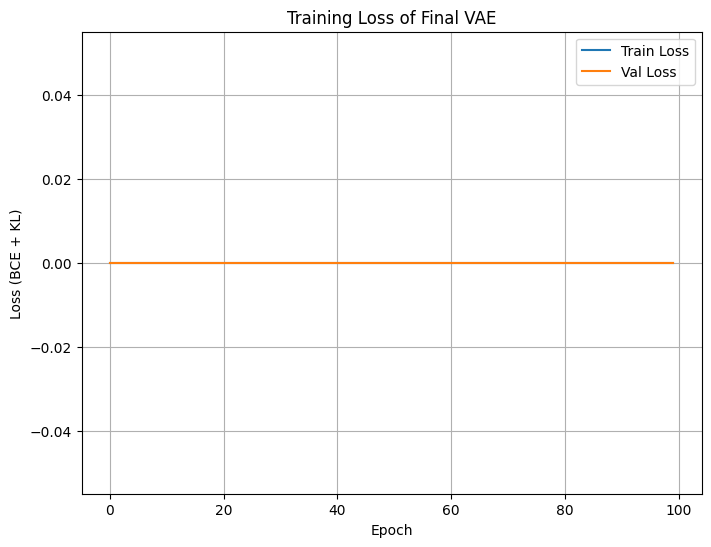

3824

In [9]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import matplotlib.pyplot as plt
import gc

# Asegúrate de que train_dataset, val_dataset (y test_dataset) tengan imágenes normalizadas en [0,1]

# Iniciar sesión y configurar W&B
wandb.login()
wandb.init(project="VAE + DAE", name="Final_VAE_512x512", config={
    "epochs": 100,
    "batch_size": 4,
    "img_size": IMG_SIZE,
    "latent_dim": LATENT_DIM,
    "optimizer": "adam",
    "loss": "bce+kl",
    "architecture": f"Final_VAE with {IMG_SIZE}x{IMG_SIZE} and latent_dim {LATENT_DIM}",
    "mixed_precision": "disabled"
})

# Definir callbacks para W&B
callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="final_vae_best.keras", save_weights_only=False)
]

# Entrenar el modelo
history = final_vae_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Guardar el modelo y registrarlo como artifact en W&B
final_vae_model.save("final_vae_model.h5")
artifact = wandb.Artifact("final_vae_model", type="model")
artifact.add_file("final_vae_model.h5")
wandb.log_artifact(artifact)
wandb.finish()

# Graficar la historia de entrenamiento
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (BCE + KL)")
plt.title("Training Loss of Final VAE")
plt.legend()
plt.grid(True)
plt.show()

gc.collect()

In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr_metric, structural_similarity as ssim_metric
import numpy as np

# Evaluar el modelo en el test_dataset (usando el test_step personalizado)
test_loss = final_vae_model.evaluate(test_dataset)
print("Test Loss:", test_loss)

# Calcular PSNR y SSIM en un batch del test_dataset
for test_batch, _ in test_dataset.take(1):
    reconstructed_batch = final_vae_model.predict(test_batch)
    psnr_vals = []
    ssim_vals = []
    for i in range(test_batch.shape[0]):
        true_img = np.array(test_batch[i])
        recon_img = np.array(reconstructed_batch[i])
        psnr_val = psnr_metric(true_img, recon_img, data_range=1.0)
        # Usar channel_axis en lugar de multichannel para las versiones recientes de scikit-image
        ssim_val = ssim_metric(true_img, recon_img, data_range=1.0, channel_axis=-1)
        psnr_vals.append(psnr_val)
        ssim_vals.append(ssim_val)
    break

print("Average PSNR on Test Batch: {:.2f} dB".format(np.mean(psnr_vals)))
print("Average SSIM on Test Batch: {:.4f}".format(np.mean(ssim_vals)))

# Función para calcular la métrica personalizada MVD
def calc_mvd(real_images, gen_images):
    real_flat = real_images.reshape(-1, IMG_SIZE * IMG_SIZE * 3)
    gen_flat = gen_images.reshape(-1, IMG_SIZE * IMG_SIZE * 3)
    mean_real, var_real = np.mean(real_flat), np.var(real_flat)
    mean_gen, var_gen = np.mean(gen_flat), np.var(gen_flat)
    mvd = np.linalg.norm(np.array([mean_real, var_real]) - np.array([mean_gen, var_gen]))
    return mvd

# Generar imágenes sintéticas usando el decoder directamente
n_samples = X_test.shape[0]
z_samples = np.random.normal(size=(n_samples, LATENT_DIM))
gen_images = final_decoder.predict(z_samples)

mvd_score = calc_mvd(X_test, gen_images)
print(f"Mean and Variance Distance (MVD): {mvd_score:.4f}")

# Registrar métricas de evaluación en W&B
wandb.init(project="VAE + DAE", name="Final_VAE_Evaluation", reinit=True)
wandb.log({
    "Test_Loss": test_loss,
    "Average_PSNR": np.mean(psnr_vals),
    "Average_SSIM": np.mean(ssim_vals),
    "MVD": mvd_score
})
wandb.finish()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 109255.6172
Test Loss: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Average PSNR on Test Batch: 14.31 dB
Average SSIM on Test Batch: 0.4612
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step
Mean and Variance Distance (MVD): 0.2862


Average_PSNR,▁
Average_SSIM,▁
MVD,▁
Test_Loss,▁
Average_PSNR,14.30825
Average_SSIM,0.46118
MVD,0.28618
Test_Loss,0


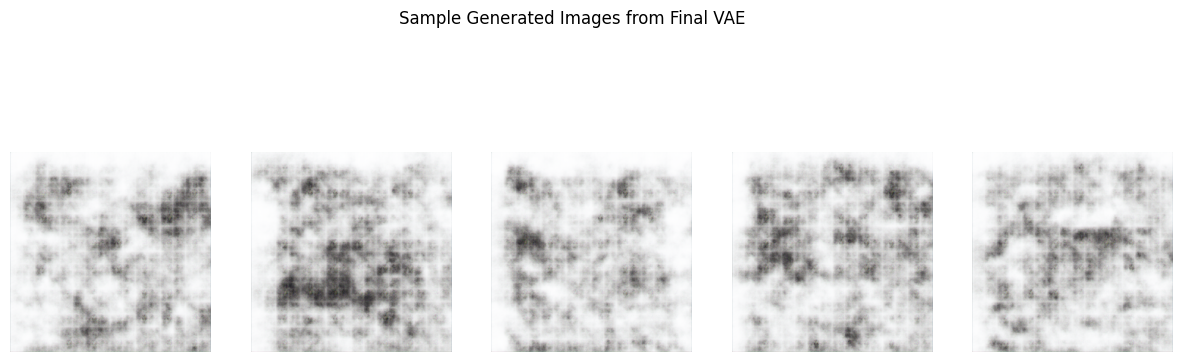

In [12]:
# Visualizar algunas imágenes generadas
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(gen_images[i])
    plt.axis('off')
plt.suptitle("Sample Generated Images from Final VAE")
plt.show()

# Registrar las imágenes generadas en W&B
wandb.init(project="VAE + DAE", name="Final_VAE_Generated_Images", reinit=True)
wandb.log({"Generated_Images": [wandb.Image(img) for img in gen_images[:5]]})
wandb.finish()


In [ ]:
#!pip install wandb tensorflow keras gradio

In [8]:
# Celda 1: Configuración inicial y preparación de datos para VAEs individuales

import os, glob, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbCallback
import gc

# Semilla para reproducibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Definir tamaño de imagen (asumiendo imágenes cuadradas, ej. 512x512)
IMG_SIZE = 512

# Rutas de las carpetas de imágenes (ajusta los paths según tu estructura)
folder_motorcycle = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/_motorcycles_ - Buscar con Google"
folder_clock = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/clock_2"  # Ajusta el path para imágenes de clock

# Obtener rutas de imágenes
paths_motorcycle = glob.glob(os.path.join(folder_motorcycle, "*"))
paths_clock = glob.glob(os.path.join(folder_clock, "*"))

# Mezclar aleatoriamente
random.shuffle(paths_motorcycle)
random.shuffle(paths_clock)

def split_paths(paths):
    num = len(paths)
    train = paths[:int(0.7 * num)]
    val   = paths[int(0.7 * num):int(0.85 * num)]
    test  = paths[int(0.85 * num):]
    return train, val, test

# Dividir rutas por clase
train_paths_moto, val_paths_moto, test_paths_moto = split_paths(paths_motorcycle)
train_paths_clock, val_paths_clock, test_paths_clock = split_paths(paths_clock)

# Función de preprocesamiento (carga y normaliza la imagen a [0,1])
def preprocess_image(image_path, img_size=IMG_SIZE):
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    return img

# Cargar y preprocesar imágenes para cada clase
X_train_moto = np.array([preprocess_image(p) for p in train_paths_moto])
X_val_moto   = np.array([preprocess_image(p) for p in val_paths_moto])
X_test_moto  = np.array([preprocess_image(p) for p in test_paths_moto])

X_train_clock = np.array([preprocess_image(p) for p in train_paths_clock])
X_val_clock   = np.array([preprocess_image(p) for p in val_paths_clock])
X_test_clock  = np.array([preprocess_image(p) for p in test_paths_clock])

print("Motorcycle - Train:", X_train_moto.shape, "Val:", X_val_moto.shape, "Test:", X_test_moto.shape)
print("Clock - Train:", X_train_clock.shape, "Val:", X_val_clock.shape, "Test:", X_test_clock.shape)

# Liberar memoria si es necesario
gc.collect()

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Motorcycle - Train: (152, 512, 512, 3) Val: (33, 512, 512, 3) Test: (33, 512, 512, 3)
Clock - Train: (243, 512, 512, 3) Val: (52, 512, 512, 3) Test: (53, 512, 512, 3)


268

In [26]:
# Celda 2: Definición de la arquitectura VAE

from tensorflow.keras import layers, Model, Input

def build_vae(latent_dim, img_size=IMG_SIZE):
    # --- Encoder ---
    encoder_inputs = Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    # Obtener medias y log-varianzas
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Truco de reparametrización
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean), seed=seed)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # --- Decoder ---
    latent_inputs = Input(shape=(latent_dim,))
    x = layers.Dense((img_size // 16) * (img_size // 16) * 256, activation='relu')(latent_inputs)
    x = layers.Reshape((img_size // 16, img_size // 16, 256))(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    decoder_outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    # --- VAE Completo ---
    outputs = decoder(z)
    vae = Model(encoder_inputs, outputs, name="vae")

    # Define the VAE loss as a custom function
    def vae_loss_fn(y_true, y_pred):
        # Reconstrucción
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.mse(
                tf.keras.layers.Flatten()(encoder_inputs),
                tf.keras.layers.Flatten()(outputs)
            )
        )
        reconstruction_loss *= img_size * img_size * 3

        # KL divergence
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = -0.5 * tf.reduce_mean(kl_loss)

        # Total loss
        total_loss = reconstruction_loss + kl_loss
        return total_loss

    vae.add_loss(tf.reduce_mean(vae_loss_fn(encoder_inputs, outputs)))

    return vae, encoder, decoder

In [27]:
# Celda 3: Instanciar y compilar los VAEs para cada clase

LATENT_DIM = 256  # Puedes ajustar este valor según tus experimentos

# VAE para Motorcycle
vae_moto, encoder_moto, decoder_moto = build_vae(LATENT_DIM, img_size=IMG_SIZE)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
vae_moto.compile(optimizer=optimizer)

# VAE para Clock
vae_clock, encoder_clock, decoder_clock = build_vae(LATENT_DIM, img_size=IMG_SIZE)
vae_clock.compile(optimizer=optimizer)

# Mostrar resúmenes de ambos modelos
vae_moto.summary()
vae_clock.summary()

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# Celda 4: Entrenamiento de los VAEs individuales con registro en WandB

# --- VAE para Motorcycle ---
wandb.login(key="84acb992804885251a1080b55a34890b5cec77eb")
run_moto = wandb.init(entity="arturo-torres-iteso", project="VAE + DAE", name="VAE_Motorcycle", reinit=True)

history_moto = vae_moto.fit(
    X_train_moto,
    X_train_moto,
    epochs=100,            # Ajusta las épocas según necesidad
    batch_size=8,
    validation_data=(X_val_moto, X_val_moto),
    callbacks=[WandbCallback(save_model=False)]
)

# Guardar pesos del modelo en WandB
vae_moto.save("vae_moto_model.h5")
wandb.save("vae_moto_model.h5")
wandb.finish()

tf.keras.backend.clear_session()
gc.collect()

# --- VAE para Clock ---
run_clock = wandb.init(project="VAE + DAE", name="VAE_Clock", reinit=True)

history_clock = vae_clock.fit(
    X_train_clock,
    X_train_clock,
    epochs=50,            # Ajusta las épocas según necesidad
    batch_size=8,
    validation_data=(X_val_clock, X_val_clock),
    callbacks=[WandbCallback(save_model=False)]
)

# Guardar pesos del modelo en WandB
vae_clock.save("vae_clock_model.h5")
wandb.save("vae_clock_model.h5")
wandb.finish()

tf.keras.backend.clear_session()
gc.collect()

In [ ]:
# Celda 5: Evaluación de los VAEs utilizando la métrica MVD

def calc_mvd(real_images, gen_images):
    real_flat = real_images.reshape(real_images.shape[0], -1)
    gen_flat = gen_images.reshape(gen_images.shape[0], -1)
    mean_real = np.mean(real_flat, axis=0)
    std_real = np.std(real_flat, axis=0)
    mean_gen = np.mean(gen_flat, axis=0)
    std_gen = np.std(gen_flat, axis=0)
    mean_distance = np.linalg.norm(mean_real - mean_gen)
    std_distance = np.linalg.norm(std_real - std_gen)
    return mean_distance + std_distance

# Evaluación para Motorcycle VAE
n_samples_moto = len(X_test_moto)
z_samples_moto = np.random.normal(size=(n_samples_moto, LATENT_DIM))
gen_images_moto = decoder_moto.predict(z_samples_moto)
mvd_moto = calc_mvd(X_test_moto, gen_images_moto)
print(f"Motorcycle VAE - Mean and Variance Distance (MVD): {mvd_moto:.2f}")

# Registrar métrica en WandB
run_eval_moto = wandb.init(project="VAE + DAE", name="VAE_Motorcycle_Evaluation", reinit=True)
wandb.log({"MVD_Motorcycle": mvd_moto})
wandb.finish()

# Evaluación para Clock VAE
n_samples_clock = len(X_test_clock)
z_samples_clock = np.random.normal(size=(n_samples_clock, LATENT_DIM))
gen_images_clock = decoder_clock.predict(z_samples_clock)
mvd_clock = calc_mvd(X_test_clock, gen_images_clock)
print(f"Clock VAE - Mean and Variance Distance (MVD): {mvd_clock:.2f}")

# Registrar métrica en WandB
run_eval_clock = wandb.init(project="VAE + DAE", name="VAE_Clock_Evaluation", reinit=True)
wandb.log({"MVD_Clock": mvd_clock})
wandb.finish()

In [ ]:
# Celda Extra: Evaluación de Métricas Adicionales (MSE, PSNR y SSIM)

import tensorflow as tf
import numpy as np

def evaluate_metrics(model, X_test, class_name):
    """
    Evalúa las métricas de reconstrucción para un modelo VAE.

    Parámetros:
    - model: Modelo VAE (se utiliza para reconstruir las imágenes de test).
    - X_test: Conjunto de imágenes de test (preprocesadas, rango [0,1]).
    - class_name: Nombre de la clase (para registro y mensajes).

    Calcula:
    - MSE: Error Cuadrático Medio entre las imágenes originales y reconstruidas.
    - PSNR: Peak Signal-to-Noise Ratio (rango en dB).
    - SSIM: Structural Similarity Index (entre 0 y 1).

    Registra las métricas en WandB y las imprime.
    """
    # Reconstruir imágenes del conjunto de test
    X_reconstructed = model.predict(X_test)

    # Calcular MSE
    mse_value = np.mean((X_test - X_reconstructed) ** 2)

    # Calcular PSNR usando la función de TensorFlow (asumiendo max_val=1.0)
    psnr_values = tf.image.psnr(X_test, X_reconstructed, max_val=1.0).numpy()
    psnr_avg = np.mean(psnr_values)

    # Calcular SSIM usando la función de TensorFlow (asumiendo max_val=1.0)
    ssim_values = tf.image.ssim(X_test, X_reconstructed, max_val=1.0).numpy()
    ssim_avg = np.mean(ssim_values)

    # Imprimir resultados
    print(f"{class_name} VAE - Reconstruction Metrics:")
    print(f"  MSE  : {mse_value:.4f}")
    print(f"  PSNR : {psnr_avg:.4f} dB")
    print(f"  SSIM : {ssim_avg:.4f}")

    # Registrar métricas en WandB
    wandb.log({
        f"{class_name}_Reconstruction_MSE": mse_value,
        f"{class_name}_Reconstruction_PSNR": psnr_avg,
        f"{class_name}_Reconstruction_SSIM": ssim_avg
    })

    return mse_value, psnr_avg, ssim_avg

# Evaluar métricas para el VAE de Motorcycle
print("Evaluación del VAE para Motorcycle:")
mse_moto, psnr_moto, ssim_moto = evaluate_metrics(vae_moto, X_test_moto, "Motorcycle")

# Evaluar métricas para el VAE de Clock
print("\nEvaluación del VAE para Clock:")
mse_clock, psnr_clock, ssim_clock = evaluate_metrics(vae_clock, X_test_clock, "Clock")

In [ ]:
# Celda 6: Visualización y registro de imágenes generadas en WandB

def display_generated_images(gen_images, title):
    plt.figure(figsize=(10, 5))
    n = min(5, gen_images.shape[0])
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(gen_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualización para Motorcycle VAE
display_generated_images(gen_images_moto, "Generated Images - Motorcycle VAE")

# Visualización para Clock VAE
display_generated_images(gen_images_clock, "Generated Images - Clock VAE")

# Registro de imágenes en WandB
run_vis = wandb.init(project="VAE + DAE", name="Generated_Images", reinit=True)
wandb.log({
    "Generated_Images_Motorcycle": [wandb.Image(img) for img in gen_images_moto[:5]],
    "Generated_Images_Clock": [wandb.Image(img) for img in gen_images_clock[:5]]
})
wandb.finish()

In [ ]:
# Celda 7: Creación de la interfaz interactiva con Gradio

import gradio as gr

def generate_images(class_choice, num_images):
    # Semilla para mantener reproducibilidad en la generación
    np.random.seed(seed)
    if class_choice.lower() == "motorcycle":
        z_samples = np.random.normal(size=(num_images, LATENT_DIM))
        generated = decoder_moto.predict(z_samples)
    elif class_choice.lower() == "clock":
        z_samples = np.random.normal(size=(num_images, LATENT_DIM))
        generated = decoder_clock.predict(z_samples)
    else:
        return "Clase no reconocida. Elige 'Motorcycle' o 'Clock'."
    # Retornar lista de imágenes
    return [generated[i] for i in range(num_images)]

iface = gr.Interface(
    fn=generate_images,
    inputs=[
        gr.inputs.Dropdown(choices=["Motorcycle", "Clock"], label="Clase"),
        gr.inputs.Slider(minimum=1, maximum=10, step=1, default=5, label="Número de Imágenes")
    ],
    outputs=gr.outputs.Gallery(label="Imágenes Generadas"),
    title="Generación de Imágenes con VAE Individual por Clase",
    description="Selecciona una clase y el número de imágenes a generar."
)

iface.launch()

In [ ]:
# Celda 8: Placeholder para la implementación del DAE
# Aquí se implementará el Denoising Autoencoder (DAE) siguiendo:
# - Agregar ruido (Gaussiano, sal y pimienta) a las imágenes de entrenamiento.
# - Entrenar el DAE y evaluarlo con imágenes ruidosas.
# - Registrar entrenamiento y métricas en WandB.
print("Implementación del DAE pendiente.")

---

# Hasta aqui llevamos

Esto proporcionará un link donde interactuar con la app. En Colab, `debug=False` evita log verbose; también se puede usar `share=True` para obtener un enlace público aunque W&B y HF Spaces suelen ser mejores para compartir formalmente.

### 4.2 Despliegue en Hugging Face Spaces con Autenticación
Para desplegar esta demo en Hugging Face Spaces, necesitamos:
1. Tener una cuenta en Hugging Face y un **token de autenticación** con permisos de *write*.
2. Crear un nuevo Space (por ejemplo, en la web de Hugging Face, podemos crear un Space de tipo Gradio, repositorio vacío).
3. Desde Colab, clonaremos ese repositorio Space, añadiremos nuestro código de la app (un archivo `app.py` con la interfaz Gradio, requisitos, etc.), y luego haremos push.

Instalemos la herramienta de Huggingface Hub:

In [ ]:
!pip install huggingface_hub
from huggingface_hub import HfApi, Repository, login

# Login a Hugging Face using token (reemplaza 'YOUR_HF_TOKEN' con el tuyo)
login(token="YOUR_HF_TOKEN")

A continuación, clonamos el repositorio del Space. Debes reemplazar `"usuario/nombre-del-space"` con tu usuario de HF y el nombre que hayas elegido para el Space:

In [ ]:
# Clonar el repositorio del Space
repo_url = "https://huggingface.co/spaces/usuario/nombre-del-space"
local_dir = "my_gradio_space"
repo = Repository(local_dir=local_dir, clone_from=repo_url)

Ahora debemos preparar los archivos para el Space:
- Un archivo `app.py` con la aplicación Gradio (similar a lo que definimos arriba).
- Un archivo `requirements.txt` listando las dependencias (e.g., `gradio`, `tensorflow`, `wandb` si se necesita, etc.). En este caso necesitaremos al menos `gradio` y `tensorflow` para que el Space instale esas librerías.
- Los archivos de modelo guardados (`dae_model.h5`, `vae_decoder.h5`, etc.) deben ser incluidos en el repo, ya que la app los cargará para funcionar. Alternativamente, podemos subirlos como *datasets* o *artifacts* y hacer que la app los descargue, pero es más sencillo adjuntarlos al Space dado que no son muy pesados para este ejemplo.

Crearemos el archivo `app.py` dentro de nuestro repositorio clonado:

In [ ]:
%%bash
cat > my_gradio_space/app.py << 'PYCODE'

In [ ]:
import gradio as gr
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Cargar modelos (asume que los .h5 están en el mismo directorio en el Space)
dae_model = load_model("dae_model.h5")
decoder = load_model("vae_decoder.h5")
latent_dim = decoder.inputs[0].shape[-1]  # obtener dim latente desde el modelo

def denoise_image(input_img):
    img = input_img.resize((64, 64)).convert("RGB")
    img_array = np.array(img, dtype=np.float32) / 255.0
    # Añadir ruido (gaussiano o sal&pimienta aleatoriamente)
    if np.random.rand() < 0.5:
        noise = np.random.normal(0, 0.1, img_array.shape)
        noisy = np.clip(img_array + noise, 0, 1)
    else:
        noisy = img_array.copy()
        prob = 0.1
        rnd = np.random.rand(*img_array.shape)
        noisy[rnd < prob/2] = 0.0
        noisy[rnd > 1 - prob/2] = 1.0
    # Pasar por DAE
    output = dae_model.predict(noisy[np.newaxis, ...])[0]
    noisy_img = Image.fromarray((noisy * 255).astype('uint8'))
    output_img = Image.fromarray((output * 255).astype('uint8'))
    return noisy_img, output_img

def generate_image(seed):
    if seed is not None:
        np.random.seed(int(seed))
    z = np.random.normal(size=(1, latent_dim))
    gen = decoder.predict(z)[0]
    gen_img = Image.fromarray((gen * 255).astype('uint8'))
    return gen_img

dae_interface = gr.Interface(fn=denoise_image,
                             inputs=gr.Image(label="Sube una imagen"),
                             outputs=[gr.Image(label="Imagen con ruido"), gr.Image(label="Imagen denoised")],
                             title="Denoising Autoencoder",
                             description="Sube una imagen de una moto o auto, el modelo le añadirá ruido y luego intentará limpiarla.")
vae_interface = gr.Interface(fn=generate_image,
                             inputs=gr.Number(label="Semilla (opcional)"),
                             outputs=gr.Image(label="Imagen generada"),
                             title="Variational Autoencoder",
                             description="Genera una imagen de moto/auto sintética a partir de un vector aleatorio (puedes cambiar la semilla para reproducir resultados).")

demo = gr.TabbedInterface([dae_interface, vae_interface], ["DAE - Denoise", "VAE - Generate"])
demo.launch()

También creamos el `requirements.txt`:


In [ ]:
%%bash
echo "gradio\ntensorflow==2.9.2" > my_gradio_space/requirements.txt

*(Nota: especificamos una versión de TensorFlow compatible con el entorno de Spaces. También podríamos añadir `wandb` si quisiéramos que la app integre tracking, pero para inferencia no es necesario.)*

Ahora movemos los archivos de modelo guardados al directorio del Space:

In [ ]:
!cp dae_model.h5 my_gradio_space/
!cp vae_decoder.h5 my_gradio_space/

Finalmente, hacemos commit y push al repositorio del Space:

In [ ]:
repo.push_to_hub(commit_message="Initial commit - add Gradio app and models")



Tras unos minutos (que el Space instale dependencias y arranque), la app debería estar disponible en `https://huggingface.co/spaces/usuario/nombre-del-space`. Si el Space es **privado**, solo usuarios con acceso (o con el token) podrán verlo; si es público, cualquiera puede interactuar con la demo. Podemos controlar la visibilidad desde la configuración del Space en Hugging Face.

**Autenticación**: En el código de despliegue, autenticamos con `login(token=...)` para poder clonar y subir al Space. Asegúrate de mantener tu token seguro (no compartirlo públicamente). Una práctica común es almacenarlo como variable de entorno o usar la interfaz de Colab para introducirlo en lugar de hardcodearlo en el notebook.

## 5. Automatización y Eficiencia en Colab
En esta última sección, resumimos estrategias empleadas y recomendaciones para ejecutar eficientemente este pipeline en Google Colab (u otros entornos similares):

- **Carga de Datos en Batches**: En lugar de cargar todas las imágenes a la vez en la GPU, usamos `tf.data` para cargar por lotes y añadimos ruido sobre la marcha. Esto reduce el pico de memoria y aprovecha el *pipeline* asíncrono para alimentar la GPU constantemente.
- **Liberación de Memoria**: Después de entrenar el DAE, liberamos recursos (modelo y grafo de TF) antes de iniciar el VAE. Esto se hizo con `del modelo`, `clear_session()` y `gc.collect()`, evitando acumulación de uso de GPU/CPU RAM.
- **Monitorización con W&B**: Usamos W&B no solo para métricas sino también para almacenar los modelos y pesos. De esta forma, si Colab se desconecta o reinicia, podemos recuperar los modelos entrenados desde W&B fácilmente (usando artefactos). Automatizar el registro y carga de artefactos en W&B asegura que no se pierda el trabajo y facilita reproducibilidad.
- **Uso eficiente de GPU**: Nos aseguramos de utilizar `.prefetch` en los datasets para que la GPU no espere por datos. También configuramos un tamaño de batch razonable (32) que quepa en memoria pero que aproveche paralelismo. En Colab, activar el **entorno de ejecución GPU** es esencial (Runtime > Change runtime type > GPU).
- **Mixed Precision (opcional)**: Como mencionamos, aprovechar `mixed_precision` en GPUs compatibles (como Tesla T4 o superiores en Colab) puede acelerar entrenamiento y reducir consumo de memoria, lo cual es valioso en VAEs u otros modelos grandes.
- **Modularización del Código**: Organizamos el código en funciones (`build_dae`, funciones de ruido, etc.) y secciones lógicas separadas, lo que facilita pruebas por separado (por ejemplo, podríamos probar el DAE sin involucrar el VAE) y mantiene el notebook ordenado. Esto es útil para automatización, ya que podemos reusar componentes. Además, colocamos todo en un único notebook secuencialmente, permitiendo ejecutar todo de corrido en Colab, con las dependencias instaladas al inicio y los pasos bien documentados.
- **Registro de Resultados y Modelos**: Además de W&B, guardamos localmente los modelos (`.h5`) para fácilmente integrarlos a la demo. Esto muestra una práctica de guardar checkpoints de modelos durante el pipeline, lo que es recomendable para no tener que reentrenar desde cero si ocurre algún problema.

Con todo lo anterior, hemos logrado un flujo de trabajo completo: desde la **obtención de datos**, pasando por el **entrenamiento** de dos modelos de autoencoder con diferentes fines (eliminación de ruido y generación de datos), hasta una **demostración interactiva** y su despliegue, aplicando buenas prácticas de eficiencia y seguimiento de experimentos en un entorno de GPU como Colab.

¡Ahora el notebook está listo para ejecutarse paso a paso en Google Colab y reproducir el proyecto de principio a fin!